### Bike Sharing in Washington D.C. Dataset
_Rental bikes in 2011 and 2012 with corresponding weather and seasonal info_

In [1]:
# Import Package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# import sidetable as stb
pd.options.display.max_columns = 999

Dataset Source: https://www.kaggle.com/marklvl/bike-sharing-dataset

Dataset characteristics

Both hour.csv and day.csv have the following fields, except hr which is not available in day.csv
- instant: Record index
- dteday: Date
- season: Season (1:spring, 2:summer, 3:fall, 4:winter)
- yr: Year (0: 2011, 1:2012)
- mnth: Month (1 to 12)
- hr: Hour (0 to 23)
- holiday: whether day is holiday or not (extracted from Holiday Schedule)
- weekday: Day of the week
- workingday: If day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit: (extracted from Freemeteo)
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp: Normalized temperature in Celsius. The values are derived via (t-tmin)/(tmax-tmin), tmin=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-tmin)/(tmax-tmin), tmin=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

#### Reference Links
- https://www.capitalbikeshare.com/
- https://dchr.dc.gov/page/holiday-schedules-2010-and-2011
- https://dchr.dc.gov/page/holiday-schedules-2012-and-2013
- http://www.freemeteo.com
- https://www.weather.gov/jetstream/beaufort_max
- https://www.bicyclehabitat.com/how-to/a-simple-bike-maintenance-chart-pg366.htm
- http://mobility-workspace.eu/wp-content/uploads/03_Working_Paper_Costs_October_2013.pdf
- https://www.bikenbike.co.id/sepeda-bnb-11/#:~:text=Alloy%20memiliki%20umur%20yang%20lebih,itu%20kekuatan%20akan%20terus%20menurun

In [2]:
df = pd.read_csv('hour.csv',index_col=0)
df.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### Problems dan Goals

Sepeda membutuhkan pemeliharaan rutin untuk dapat dipakai (sebagai sepeda rental) dalam jangka waktu yang lama. Karena volume penggunaan sepeda bervariasi dari waktu ke waktu (e.g., bervariasi terhadap jam, bulan, tahun), maka jadwal maintenance sepeda harus terstruktur dan dinamis. Penjadwalan maintenance yang disesuaikan trend volume penggunaan sepeda diharapkan dapat memaksimumkan umur penggunaan sepeda, meminimalisir _Customer Loss_ & memaksimalkan _Customer Engagemet_ akibat kekurangan stok sepeda yang ada di lapangan ketika permitaan sepeda tinggi dan memaksimumkan _income_ apabila permintaan penggunaan sepeda selalu dapat dipenuhi.    

__Masalah__ :
- Penjadwalan maintenance yang buruk dapat mengurangi umur sepeda dan dapat menyebabkan kehilangan pelanggan (pemeliharaan sepeda mempengaruhi masualah stok di lapangan, karena sepeda yg sedang diperbaiki akan ditarik dari peredaran untuk sesaat. Disaat banyak nya sepeda yg harus diperbaiki secara bersamaan, secara tidak langsung mengurangi stok sepeda di lapangan dan menjadi potensi kehilangan customer).
- Pada hari-hari tertentu, jumlah permintaan sepeda naik/turun secara drastis.\


__Tujuan__ :
- __Features/Kolom__ apa saja yang berpengaruh terhadap penyewaan sepeda.
- Membuat __penjadwalan *maintenance*__ yang baik untuk meminimalisir _customer loss_.
- __Prediksi penggunaan sepeda__ (minimum dan maksimum) untuk meminimalisir _customer loss_ dan memperkirakan stok sepeda.


### Data Check

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 1 to 17379
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 1   season      17379 non-null  int64  
 2   yr          17379 non-null  int64  
 3   mnth        17379 non-null  int64  
 4   hr          17379 non-null  int64  
 5   holiday     17379 non-null  int64  
 6   weekday     17379 non-null  int64  
 7   workingday  17379 non-null  int64  
 8   weathersit  17379 non-null  int64  
 9   temp        17379 non-null  float64
 10  atemp       17379 non-null  float64
 11  hum         17379 non-null  float64
 12  windspeed   17379 non-null  float64
 13  casual      17379 non-null  int64  
 14  registered  17379 non-null  int64  
 15  cnt         17379 non-null  int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 2.3+ MB


In [4]:
Desc = []

for i in df.columns:
    Desc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum() )/ len(df)) * 100),2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(data = Desc,
            columns = [
                'Column',
                'DataType',
                'Null',
                'Null (%)',
                'nUnique',
                'Unique Samples'
            ])

,Column,DataType,Null,Null (%),nUnique,Unique Samples
0,dteday,object,0,0.0,731,"[2011-07-10, 2011-06-21]"
1,season,int64,0,0.0,4,"[4, 1]"
2,yr,int64,0,0.0,2,"[0, 1]"
3,mnth,int64,0,0.0,12,"[2, 1]"
4,hr,int64,0,0.0,24,"[10, 14]"
5,holiday,int64,0,0.0,2,"[1, 0]"
6,weekday,int64,0,0.0,7,"[0, 4]"
7,workingday,int64,0,0.0,2,"[1, 0]"
8,weathersit,int64,0,0.0,4,"[3, 1]"
9,temp,float64,0,0.0,50,"[0.34, 0.94]"


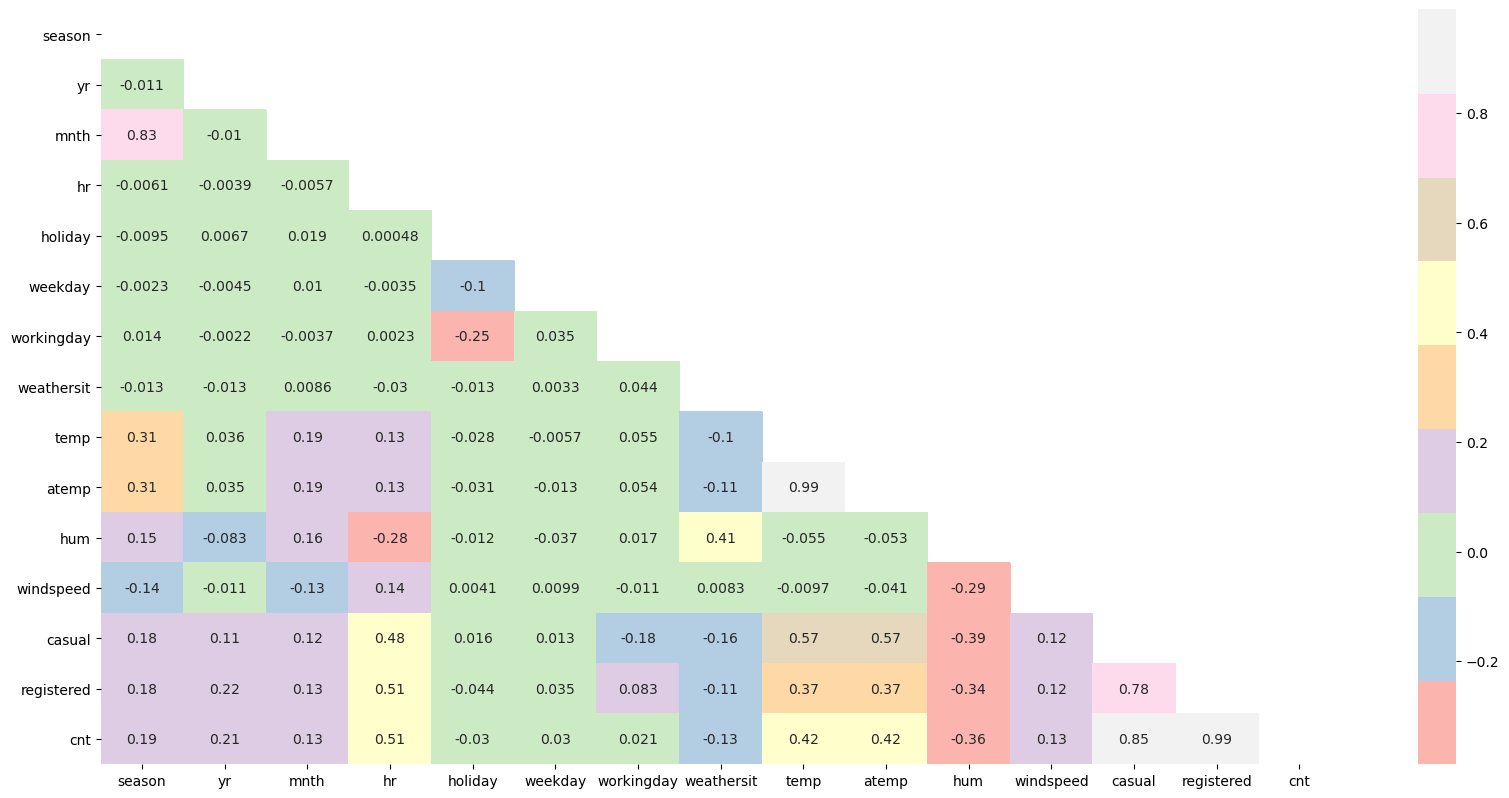

In [5]:
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(20,10),dpi=100)
sns.heatmap(df.corr('spearman'), annot=True, cmap = 'Pastel1', mask=mask)
plt.show()

### Insight
- Kolom Casual memiliki correlation terhadap kolom cnt sebesar 0.85
- Kolom Registered memiliki correlation terhadap kolom cnt sebesar 0.99
- Dikarenakan kolom cnt adalah kolom target kita, kolom Casual dan Registered tidak dianalisa lebih lanjut karena nilai korelasi yg terlalu tinggi.

### Descriptive Statistics

In [6]:
# Re-Scalling
df['temp']=(df['temp']*(39+8)-8).round(2)
df['atemp']=(df['atemp']*(50+16)-16).round(2)
df['hum']=(df['hum']*100).round(2)
df['windspeed']=(df['windspeed']*67).round(2)

In [7]:
# Numerical Columns
df.drop(columns=['dteday','season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']).describe()

,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,15.358397,15.401116,62.722884,12.736233,35.676218,153.786869,189.463088
std,9.050138,11.341858,19.292983,8.196891,49.305030,151.357286,181.387599
min,-7.060000,-16.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,7.980000,6.000000,48.000000,7.000000,4.000000,34.000000,40.000000
50%,15.500000,16.000000,63.000000,13.000000,17.000000,115.000000,142.000000
75%,23.020000,25.000000,78.000000,17.000000,48.000000,220.000000,281.000000
max,39.000000,50.000000,100.000000,57.000000,367.000000,886.000000,977.000000


In [8]:
# Categorical Columns
df['season'] = df['season'].map({1:'Winter', 2:'Spring', 3:'Summer', 4:'Fall'})
df['yr'] = df['yr'].map({0:'2011', 1:'2012'})
df['weathersit'] = df['weathersit'].map({1:'Clear', 2:'Cloudy',3:'Light Rain/Snow', 4:'Heavy Rain/Snow'})
df['workingday'] = df['workingday'].map({1:'Work', 0:'Non-Work'})
df['weekday'] = df['weekday'].map({0:'Sunday', 1:'Monday',2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday'})
df['mnth'] = df['mnth'].map({1:'January',2:'February', 3:'March', 4:'April', 5:'May', 6:'June',7:'July',8:'August', 9:'September', 10:'October', 11:'November', 12:'December'})
df['hr'] = df['hr'].astype('object')
df['holiday'] = df['holiday'].map({1:'Holiday', 0:'Non-Holiday'})


In [9]:
df.drop(columns=['dteday','temp','atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']).describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit
count,17379,17379,17379,17379,17379,17379,17379,17379
unique,4,2,12,24,2,7,2,4
top,Summer,2012,May,17,Non-Holiday,Saturday,Work,Clear
freq,4496,8734,1488,730,16879,2512,11865,11413


### Outliers

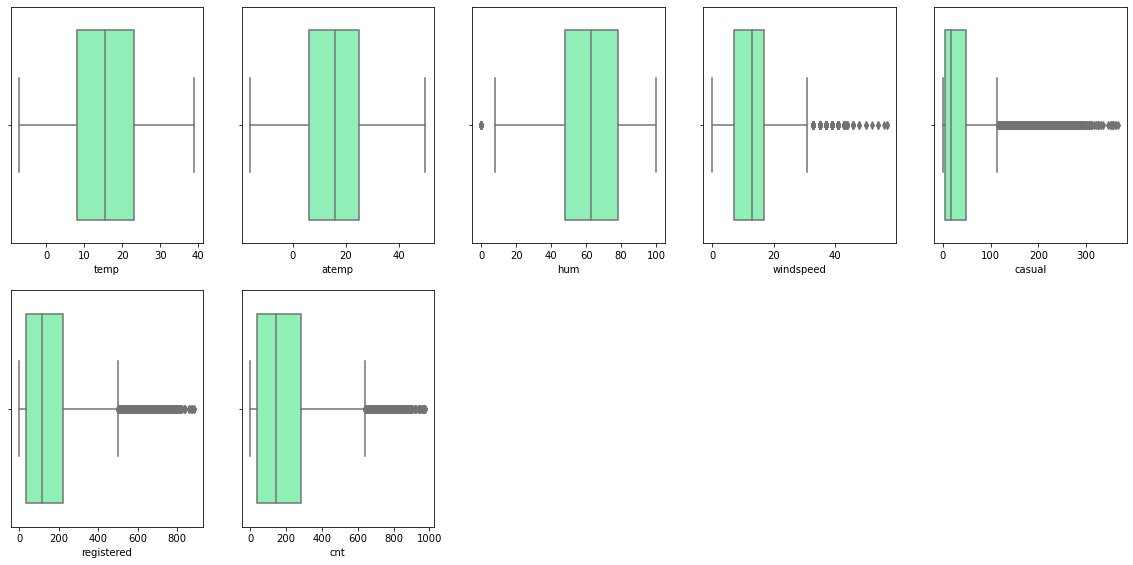

In [10]:
# Outliers by Boxplot
df_describe = df.drop(columns = ['dteday','season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit'])

plt.figure(figsize =(20, 20))
x = 1 

for column in df_describe.columns:
    plt.subplot(4,5,x)
    sns.boxplot(x=df_describe[column], palette='rainbow')
    x+=1
plt.tight_layout
plt.show()

In [11]:
# Outliers by Tabular
Desc_outliers = []

for i in df.drop(columns = ['dteday','season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']):
    Q1 = df.describe()[i]['25%']
    Q3 = df.describe()[i]['75%']
    IQR = Q3 - Q1
    upper_fence = Q3 + (1.5*IQR)
    lower_fence = Q1 - (1.5*IQR)
    hitung = 0
    
    for j in df[i]:
        if (j < lower_fence) | (j > upper_fence) :
            hitung+=1
    Desc_outliers.append([
        i,
        hitung
    ])
            
# upper_fence, lower_fence
pd.DataFrame(Desc_outliers, columns=[
    "Data Features",
    "Jumlah Outliers"
])


,Data Features,Jumlah Outliers
0,temp,0
1,atemp,0
2,hum,22
3,windspeed,342
4,casual,1192
5,registered,680
6,cnt,505


In [12]:
# Outliers Analysis
Q1 = df['cnt'].describe()['25%']
Q3 = df['cnt'].describe()['75%']
IQR = Q3 - Q1
upper_fence = Q3 + (1.5*IQR)
lower_fence = Q1 - (1.5*IQR)

df_outliers = df[(df['cnt'] < lower_fence)|(df['cnt'] > upper_fence)]
df_outliers

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
5537,2011-08-23,Summer,2011,August,14,Non-Holiday,Tuesday,Work,Clear,25.84,27.0,30.0,6.0,149,502,651
10359,2012-03-12,Winter,2012,March,17,Non-Holiday,Monday,Work,Cloudy,21.14,25.0,38.0,28.0,87,557,644
10360,2012-03-12,Winter,2012,March,18,Non-Holiday,Monday,Work,Cloudy,20.20,25.0,43.0,13.0,89,623,712
10383,2012-03-13,Winter,2012,March,17,Non-Holiday,Tuesday,Work,Clear,24.90,26.0,37.0,7.0,62,614,676
10384,2012-03-13,Winter,2012,March,18,Non-Holiday,Tuesday,Work,Clear,24.90,26.0,34.0,20.0,96,638,734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16886,2012-12-11,Fall,2012,December,8,Non-Holiday,Tuesday,Work,Cloudy,7.98,4.0,61.0,20.0,16,708,724
16910,2012-12-12,Fall,2012,December,8,Non-Holiday,Wednesday,Work,Cloudy,4.22,1.0,65.0,11.0,18,670,688
16934,2012-12-13,Fall,2012,December,8,Non-Holiday,Thursday,Work,Clear,3.28,-1.0,60.0,13.0,24,655,679


In [13]:
df_outliers['dteday'].nunique()

200

#### Insight
Terdapat 200 tanggal dimana cnt outliers

In [14]:
df['holiday'].value_counts()

Non-Holiday    16879
Holiday          500
Name: holiday, dtype: int64

In [15]:
df_outliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505 entries, 5537 to 17078
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      505 non-null    object 
 1   season      505 non-null    object 
 2   yr          505 non-null    object 
 3   mnth        505 non-null    object 
 4   hr          505 non-null    object 
 5   holiday     505 non-null    object 
 6   weekday     505 non-null    object 
 7   workingday  505 non-null    object 
 8   weathersit  505 non-null    object 
 9   temp        505 non-null    float64
 10  atemp       505 non-null    float64
 11  hum         505 non-null    float64
 12  windspeed   505 non-null    float64
 13  casual      505 non-null    int64  
 14  registered  505 non-null    int64  
 15  cnt         505 non-null    int64  
dtypes: float64(4), int64(3), object(9)
memory usage: 67.1+ KB


In [16]:
df_outliers['dteday'][df_outliers['holiday']=='Holiday'].unique()

array(['2012-04-16'], dtype=object)

#### Insight
- Monday, April 16, 2012  DC Emancipation Day

*Note: The legal public holidays for New Year’s Day and Veterans Day are Sunday, January 1, 2012 and Sunday, November 11, 2012, respectively. By law, when the holiday falls on a Sunday, it is observed on the following Monday.

In [17]:
df_outliers['dteday'][df_outliers['holiday']=='Non-Holiday'].unique()

array(['2011-08-23', '2012-03-12', '2012-03-13', '2012-03-14',
       '2012-03-15', '2012-03-17', '2012-03-19', '2012-03-20',
       '2012-03-21', '2012-03-22', '2012-03-23', '2012-03-26',
       '2012-03-27', '2012-03-28', '2012-03-29', '2012-04-02',
       '2012-04-03', '2012-04-04', '2012-04-05', '2012-04-06',
       '2012-04-07', '2012-04-09', '2012-04-10', '2012-04-12',
       '2012-04-13', '2012-04-14', '2012-04-15', '2012-04-17',
       '2012-04-19', '2012-04-20', '2012-04-21', '2012-04-24',
       '2012-04-25', '2012-04-26', '2012-04-27', '2012-04-29',
       '2012-04-30', '2012-05-01', '2012-05-02', '2012-05-03',
       '2012-05-04', '2012-05-07', '2012-05-08', '2012-05-09',
       '2012-05-10', '2012-05-11', '2012-05-12', '2012-05-15',
       '2012-05-16', '2012-05-17', '2012-05-18', '2012-05-19',
       '2012-05-22', '2012-05-23', '2012-05-24', '2012-05-25',
       '2012-05-29', '2012-05-30', '2012-05-31', '2012-06-01',
       '2012-06-02', '2012-06-03', '2012-06-04', '2012-

#### Insight
- The Nation’s largest celebration of science and engineering, the USA Science & Engineering Festival, is returning to Washington, D.C., April 28-29, 2012. Adam Savage and Jamie Hyneman, hosts of the Discovery Channel's hit TV series MythBusters, and Bill Nye the Science Guy are among the science superstars signed up to join the Festival Expo at the Walter E. Washington Convention Center and other key locations in the greater District of Columbia area. source : https://www.biospace.com/article/releases/-b-usa-science-and-engineering-festival-b-expands-for-2012-event-in-washington-d-c-/
- The 7th Annual Nations Triathlon to Benefit The Leukemia & Lymphoma Society will take place Sunday, September 9, 2012 in the nations capital, Washington, DC. https://www.trifind.com/re_64972/TheNationsTriathlon.html
- Human Rights Campaign National Dinner : Winston & Strawn served as a bronze level sponsor for the Human Rights Campaign 16th Annual National Dinner, held on October 6, 2012 in Washington, D.C https://www.winston.com/en/who-we-are/firm-profile/diversity/index.html#!/en/thought-leadership/winston-strawn-sponsors-human-rights-campaign-national-dinner.html?aj=ov&parent=5092&idx=26
- Congressional Black Caucus Foundation Legislative Conference https://www.washingtonpost.com/blogs/therootdc/post/congressional-black-caucus-what-to-do-at-the-2012-legislative-conference/2012/09/19/e4126338-0264-11e2-8102-ebee9c66e190_blog.html

#### Conclusion Outliers
Kebanyakan Outliers terjadi pada tanggal-tanggal adanya event-event tertentu, maka dari itu akan dibuat kolom baru yg mengindikasikan jika ada event atau tidak.

In [18]:
df['event'] = df['cnt'].apply(lambda x: 'No' if (x > lower_fence)&(x < upper_fence) else 'Yes')
df

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,event
instant,,,,,,,,,,,,,,,,,
1,2011-01-01,Winter,2011,January,0,Non-Holiday,Saturday,Non-Work,Clear,3.28,3.0,81.0,0.0,3,13,16,No
2,2011-01-01,Winter,2011,January,1,Non-Holiday,Saturday,Non-Work,Clear,2.34,2.0,80.0,0.0,8,32,40,No
3,2011-01-01,Winter,2011,January,2,Non-Holiday,Saturday,Non-Work,Clear,2.34,2.0,80.0,0.0,5,27,32,No
4,2011-01-01,Winter,2011,January,3,Non-Holiday,Saturday,Non-Work,Clear,3.28,3.0,75.0,0.0,3,10,13,No
5,2011-01-01,Winter,2011,January,4,Non-Holiday,Saturday,Non-Work,Clear,3.28,3.0,75.0,0.0,0,1,1,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17375,2012-12-31,Winter,2012,December,19,Non-Holiday,Monday,Work,Cloudy,4.22,1.0,60.0,11.0,11,108,119,No
17376,2012-12-31,Winter,2012,December,20,Non-Holiday,Monday,Work,Cloudy,4.22,1.0,60.0,11.0,8,81,89,No
17377,2012-12-31,Winter,2012,December,21,Non-Holiday,Monday,Work,Clear,4.22,1.0,60.0,11.0,7,83,90,No


In [19]:
df['event'].value_counts()

No     16874
Yes      505
Name: event, dtype: int64

df.to_csv('new_hour.csv')

### Exploratory Data Analysis

In [20]:
df = df.drop(columns=['registered','casual'])
df.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,event
instant,,,,,,,,,,,,,,,
1,2011-01-01,Winter,2011,January,0,Non-Holiday,Saturday,Non-Work,Clear,3.28,3.0,81.0,0.0,16,No
2,2011-01-01,Winter,2011,January,1,Non-Holiday,Saturday,Non-Work,Clear,2.34,2.0,80.0,0.0,40,No
3,2011-01-01,Winter,2011,January,2,Non-Holiday,Saturday,Non-Work,Clear,2.34,2.0,80.0,0.0,32,No
4,2011-01-01,Winter,2011,January,3,Non-Holiday,Saturday,Non-Work,Clear,3.28,3.0,75.0,0.0,13,No
5,2011-01-01,Winter,2011,January,4,Non-Holiday,Saturday,Non-Work,Clear,3.28,3.0,75.0,0.0,1,No


#### Univariate Analysis

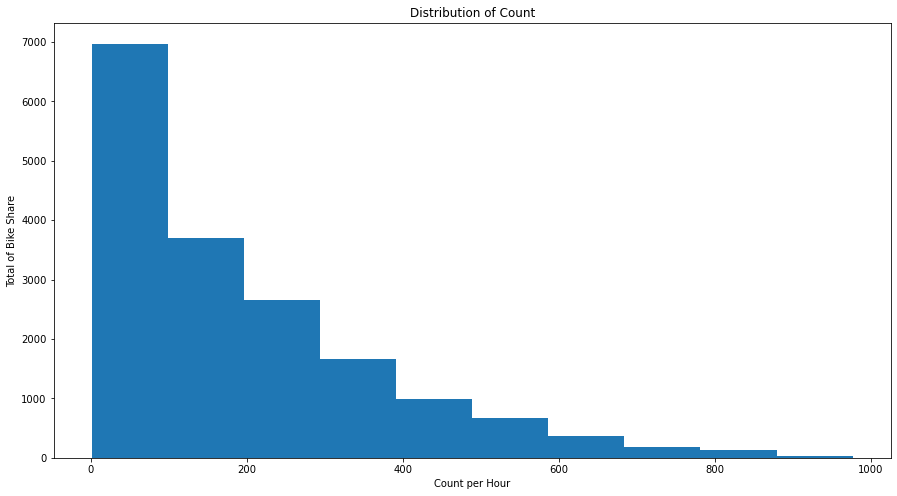

In [21]:
plt.figure(figsize=(15,8))
plt.hist(df["cnt"])
plt.title("Distribution of Count")
plt.ylabel("Total of Bike Share")
plt.xlabel("Count per Hour")
plt.show()

In [22]:
df[['season','cnt']].groupby('season').sum()

,cnt
season,
Fall,841613
Spring,918589
Summer,1061129
Winter,471348


In [23]:
df[['season','cnt']].groupby('season').mean()

,cnt
season,
Fall,198.868856
Spring,208.344069
Summer,236.016237
Winter,111.114569


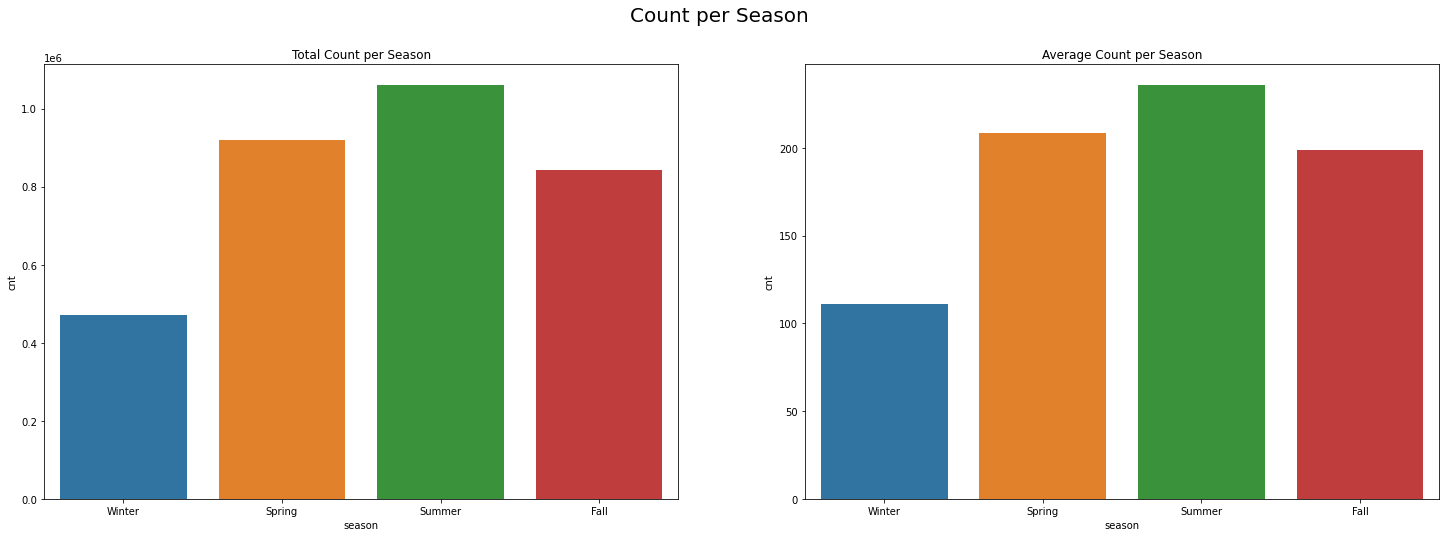

In [24]:
plt.figure(figsize=(25,8))
plt.suptitle('Count per Season',fontsize=20)
plt.subplot(1,2,1)
sns.barplot('season','cnt', data=df, estimator=sum, ci=0)
plt.title('Total Count per Season')
plt.subplot(1,2,2)
sns.barplot('season','cnt', data=df, ci=0)
plt.title('Average Count per Season')  
plt.show()

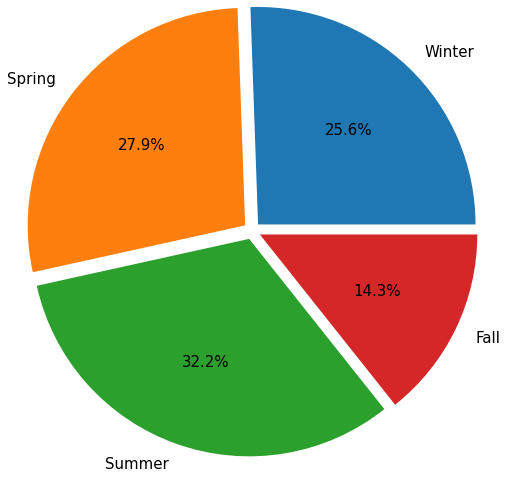

In [144]:
plt.pie(df[['season','cnt']].groupby('season').sum()['cnt'],
        labels=df['season'].unique(), autopct="%1.1f%%", 
        radius=2.5, explode=[0.1,0.1,0.1,0.1], textprops={'fontsize':15})
plt.show()

### Insight
- Season dengan Jumlah penyewaan sepeda Terbanyak ada di Season Summer dengan jumlah 1.061.129 sepeda
- Season dengan Rata-rata penyewaan sepeda Terbanyak ada di Season Summer dengan rata-rata 236,02 sepeda per jam
- Season mempengaruhi jumlah Count dengan urutan dari terbanyak ke terkecil adalah Summer - Spring - Fall - Winter

In [25]:
df[['yr','cnt']].groupby('yr').sum()

,cnt
yr,
2011,1243103
2012,2049576


In [26]:
df[['yr','cnt']].groupby('yr').mean()

,cnt
yr,
2011,143.794448
2012,234.666361


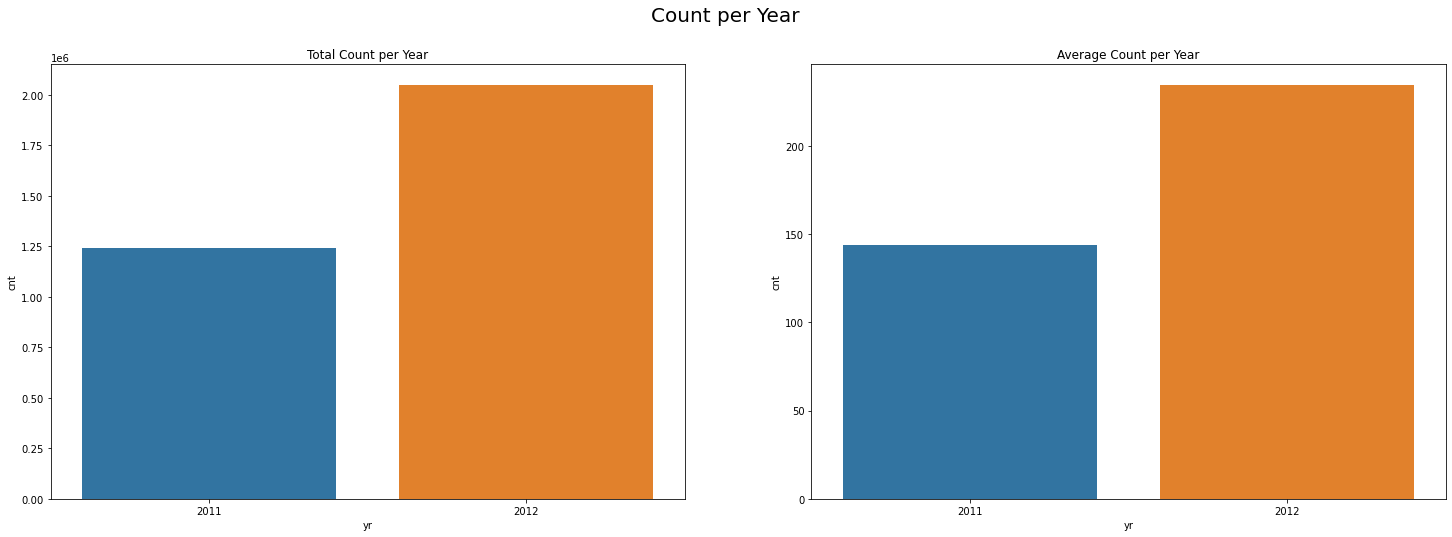

In [27]:
plt.figure(figsize=(25,8))
plt.suptitle('Count per Year',fontsize=20)
plt.subplot(1,2,1)
sns.barplot('yr','cnt', data=df, estimator=sum, ci=0)
plt.title('Total Count per Year')
plt.subplot(1,2,2)
sns.barplot('yr','cnt', data=df, ci=0)
plt.title('Average Count per Year')
plt.show()

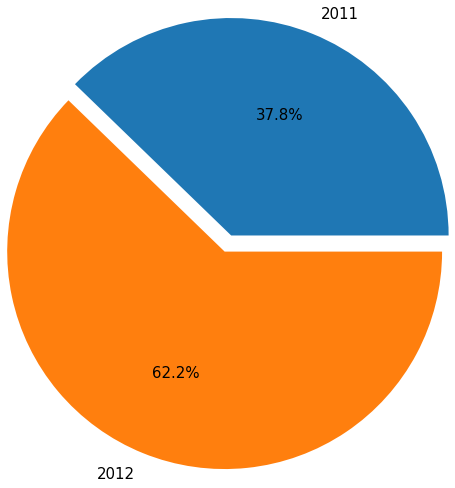

In [145]:
plt.pie(df[['yr','cnt']].groupby('yr').sum()['cnt'],
        labels=df['yr'].unique(), autopct="%1.1f%%", 
        radius=2.5, explode=[0.1,0.1], textprops={'fontsize':15})
plt.show()

### Insight
- Terjadi peningkatan Jumlah Penyewaan Sepeda sebesar 64,87% di tahun 2012 
- Jumlah Penyewaan Sepeda 1.243.103 di tahun 2011 menjadi 2.049.576 di tahun 2012
- Terjadi peningkatan Rata-rata Penyewaan Sepeda per jam sebesar 63,19% di tahun 2012
- Rata-rata Penyewaan Sepeda per jam 143,79 di tahun 2011 menjadi 234,66 di tahun 2012

In [28]:
df[['mnth','cnt']].groupby('mnth').sum()

,cnt
mnth,
April,269094
August,351194
December,211036
February,151352
January,134933
July,344948
June,346342
March,228920
May,331686


In [29]:
df[['mnth','cnt']].groupby('mnth').mean()

,cnt
mnth,
April,187.260960
August,238.097627
December,142.303439
February,112.865026
January,94.424773
July,231.819892
June,240.515278
March,155.410726
May,222.907258


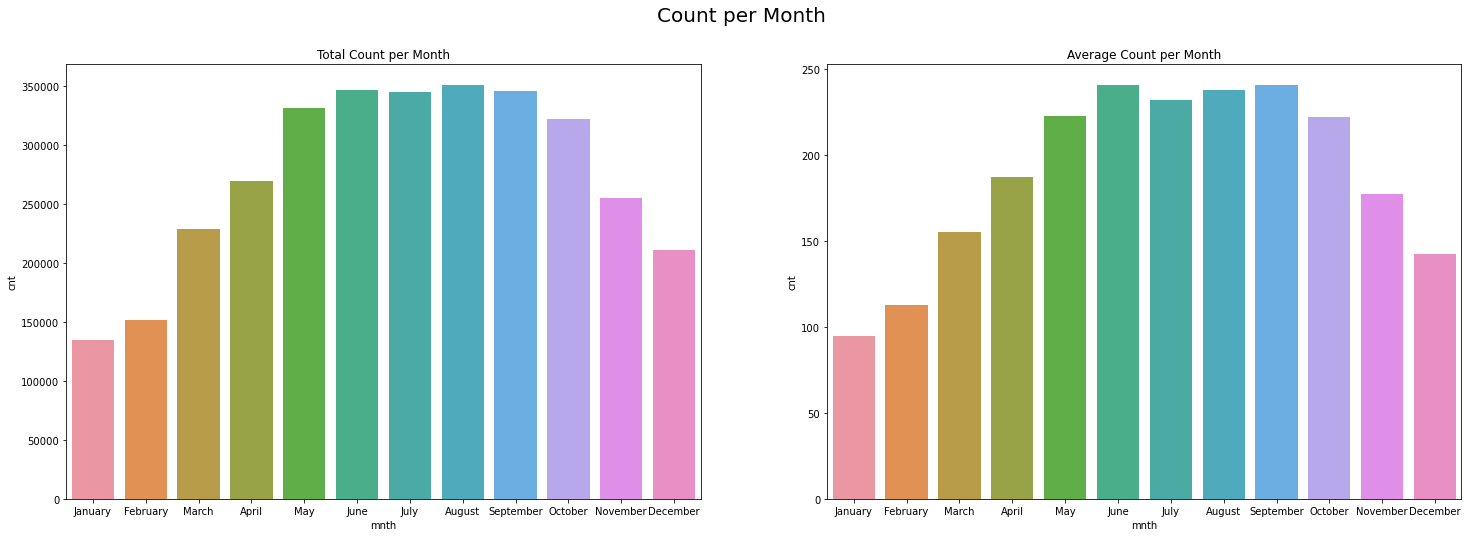

In [30]:
plt.figure(figsize=(25,8))
plt.suptitle('Count per Month',fontsize=20)
plt.subplot(1,2,1)
sns.barplot('mnth','cnt', data=df, estimator=sum, ci=0)
plt.title('Total Count per Month')
plt.subplot(1,2,2)
sns.barplot('mnth','cnt', data=df, ci=0)
plt.title('Average Count per Month')
plt.show()

plt.pie(df[['mnth','cnt']].groupby('mnth').sum()['cnt'],
        labels=df['mnth'].unique(), autopct="%1.1f%%", 
        radius=2.5, explode=[0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,], textprops={'fontsize':15})
plt.show()

### Insight
- Month dengan Jumlah penyewaan sepeda Terbanyak ada di Month August dengan jumlah 351.194 sepeda
- Month dengan Rata-rata penyewaan sepeda Terbanyak ada di Month September dengan rata-rata 240,77 sepeda per jam
- Month mempengaruhi jumlah Count melihat perbedaan jumlah dan rata rata penyewaan sepeda setiap bulannya

In [31]:
df[['hr','cnt']].groupby('hr').sum()

,cnt
hr,
0,39130
1,24164
2,16352
3,8174
4,4428
5,14261
6,55132
7,154171
8,261001


In [32]:
df[['hr','cnt']].groupby('hr').mean()

,cnt
hr,
0,53.898072
1,33.375691
2,22.869930
3,11.727403
4,6.352941
5,19.889819
6,76.044138
7,212.064649
8,359.011004


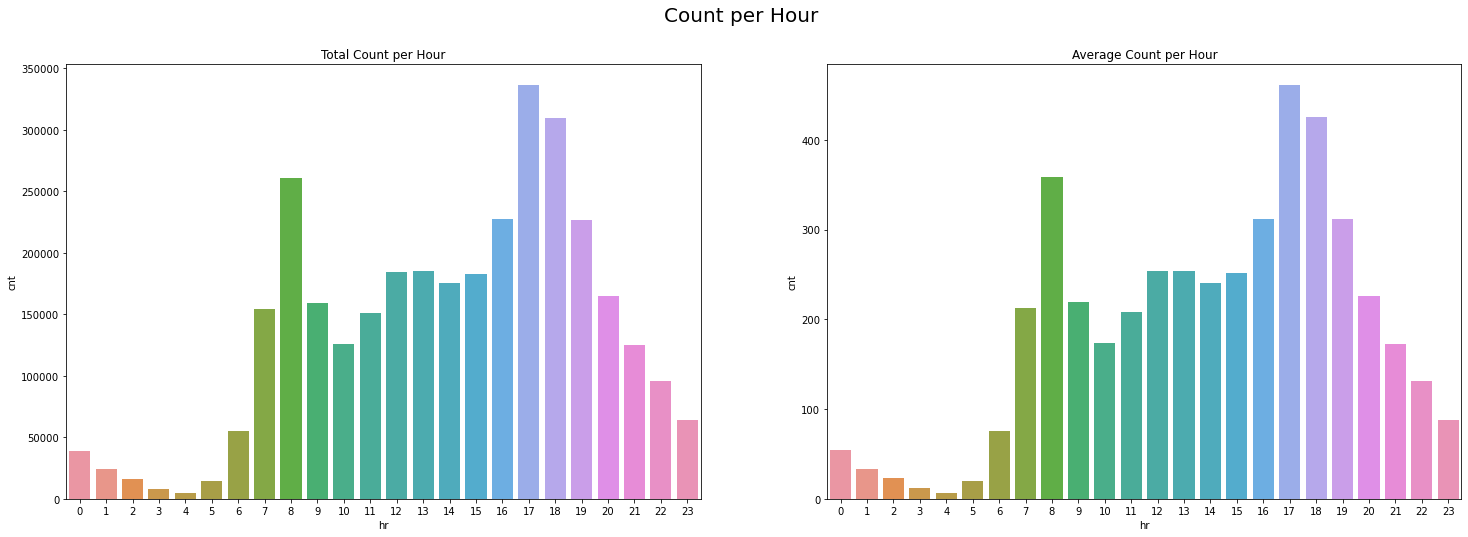

In [33]:
plt.figure(figsize=(25,8))
plt.suptitle('Count per Hour',fontsize=20)
plt.subplot(1,2,1)
sns.barplot('hr','cnt', data=df, estimator=sum, ci=0)
plt.title('Total Count per Hour')
plt.subplot(1,2,2)
sns.barplot('hr','cnt', data=df, ci=0)
plt.title('Average Count per Hour')
plt.show()

### Insight
- Hour dengan Jumlah penyewaan sepeda Tinggi pada Jam Berangkat Kerja (Hour 8) dengan jumlah 261.001 sepeda dan Jam Pulang Kerja (Hour 17) dengan jumlah 336.860 sepeda
- Hour dengan Rata-rata penyewaan sepeda Tinggi pada Jam Berangkat Kerja (Hour 8) dengan jumlah 359,01 sepeda dan Jam Pulang Kerja (Hour 17) dengan jumlah 461,45 sepeda
- Hour mempengaruhi jumlah Count melihat perbedaan jumlah dan rata rata penyewaan sepeda setiap Jam nya

In [34]:
df[['holiday','cnt']].groupby('holiday').sum()

,cnt
holiday,
Holiday,78435
Non-Holiday,3214244


In [35]:
df[['holiday','cnt']].groupby('holiday').mean()

,cnt
holiday,
Holiday,156.87000
Non-Holiday,190.42858


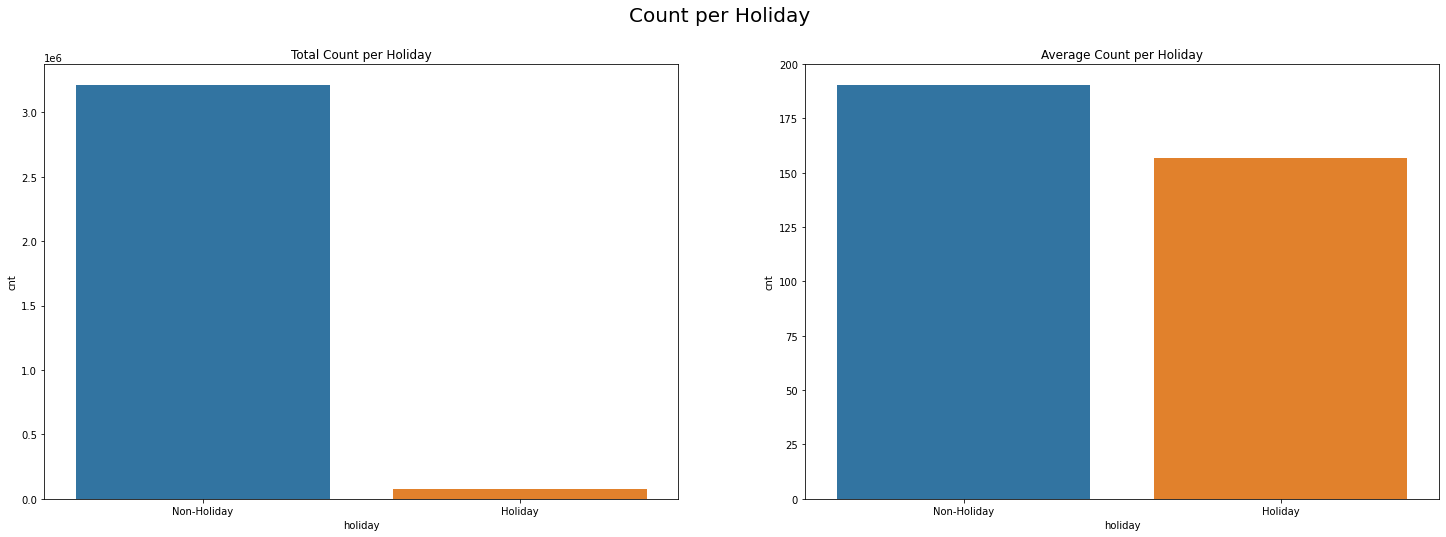

In [150]:
plt.figure(figsize=(25,8))
plt.suptitle('Count per Holiday',fontsize=20)
plt.subplot(1,2,1)
sns.barplot('holiday','cnt', data=df, estimator=sum, ci=0)
plt.title('Total Count per Holiday')
plt.subplot(1,2,2)
sns.barplot('holiday','cnt', data=df, ci=0)
plt.title('Average Count per Holiday')
plt.show()

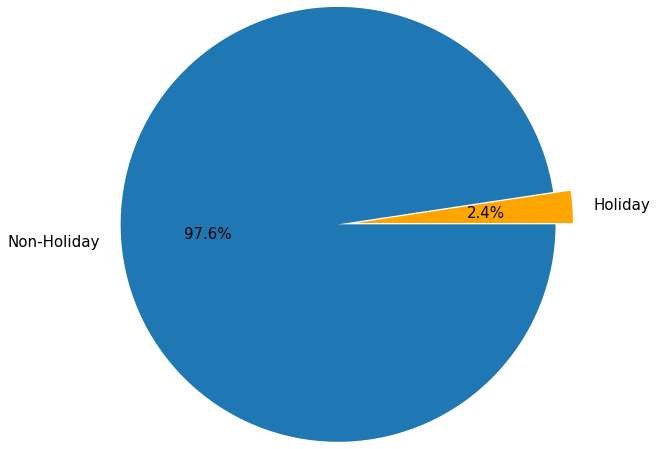

In [169]:
plt.pie(df[['holiday','cnt']].groupby('holiday').sum()['cnt'],
        labels=['Holiday','Non-Holiday'], autopct="%1.1f%%", colors=['orange', None],
        radius=2.5, explode=[0.1,0.1], textprops={'fontsize':15})
plt.show()

### Insight
- Non-Holiday memiliki Jumlah penyewaan sepeda 3.214.244, lebih banyak dibandingkan Holiday yang hanya 78.435
- Non-Holiday memiliki Rata-rata penyewaan 190,43 sepeda per jam, lebih tinggi dibandingkan Holiday dengan rata-rata penyewaan 156,87 sepeda per jam
- Holiday mempengaruhi jumlah Count dilihat dari perbedaan yang cukup siginifikan di Jumlah penyewaan sepeda

In [37]:
df[['weekday','cnt']].groupby('weekday').sum()

,cnt
weekday,
Friday,487790
Monday,455503
Saturday,477807
Sunday,444027
Thursday,485395
Tuesday,469109
Wednesday,473048


In [38]:
df[['weekday','cnt']].groupby('weekday').mean()

,cnt
weekday,
Friday,196.135907
Monday,183.744655
Saturday,190.209793
Sunday,177.468825
Thursday,196.436665
Tuesday,191.238891
Wednesday,191.130505


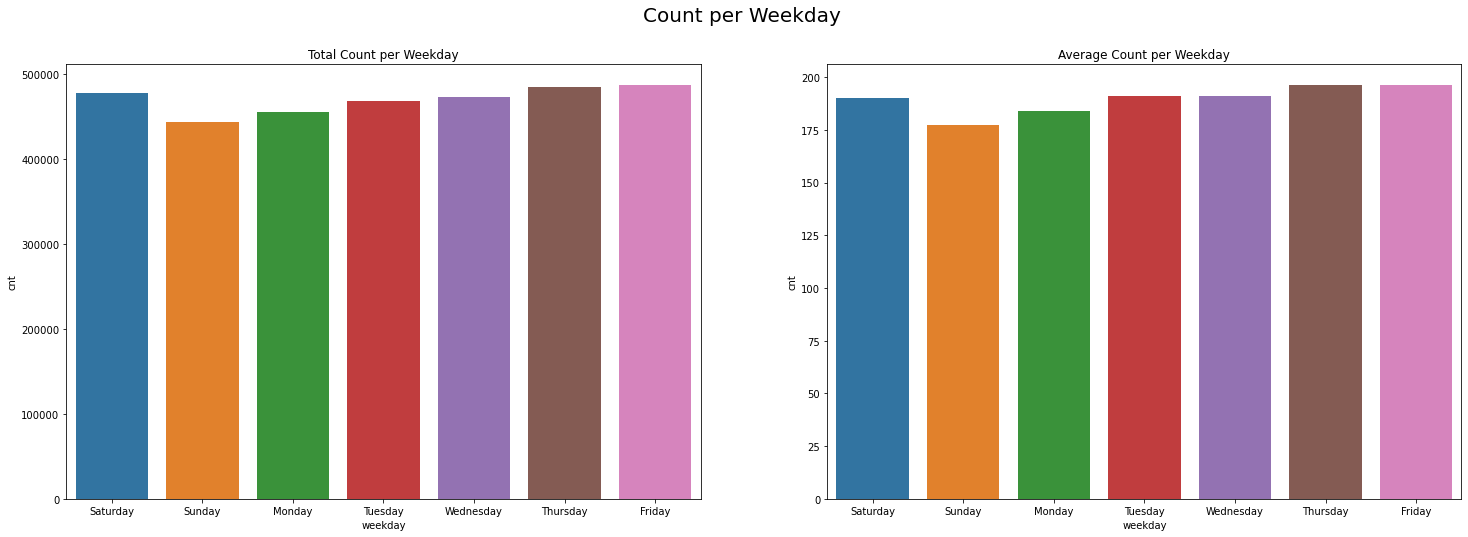

In [39]:
plt.figure(figsize=(25,8))
plt.suptitle('Count per Weekday',fontsize=20)
plt.subplot(1,2,1)
sns.barplot('weekday','cnt', data=df, estimator=sum, ci=0)
plt.title('Total Count per Weekday')
plt.subplot(1,2,2)
sns.barplot('weekday','cnt', data=df, ci=0)
plt.title('Average Count per Weekday')
plt.show()

plt.pie(df[['weekday','cnt']].groupby('weekday').sum()['cnt'],
        labels=df['weekday'].unique(), autopct="%1.1f%%", 
        radius=2.5, explode=[0.1,0.1,0.1,0.1,0.1,0.1,0.1], textprops={'fontsize':15})
plt.show()

### Insight
- Weekday dengan Jumlah penyewaan sepeda Tinggi pada Weekday Friday dengan jumlah 487.790 sepeda
- Weekday dengan Rata-rata penyewaan sepeda Tinggi pada Weekday Thursday dengan jumlah 196,44 sepeda per jam
- Weekday mempengaruhi jumlah Count melihat perbedaan jumlah dan rata rata penyewaan sepeda setiap Jam nya walau tidak siginifikan

In [40]:
df[['workingday','cnt']].groupby('workingday').sum()

,cnt
workingday,
Non-Work,1000269
Work,2292410


In [41]:
df[['workingday','cnt']].groupby('workingday').mean()

,cnt
workingday,
Non-Work,181.405332
Work,193.207754


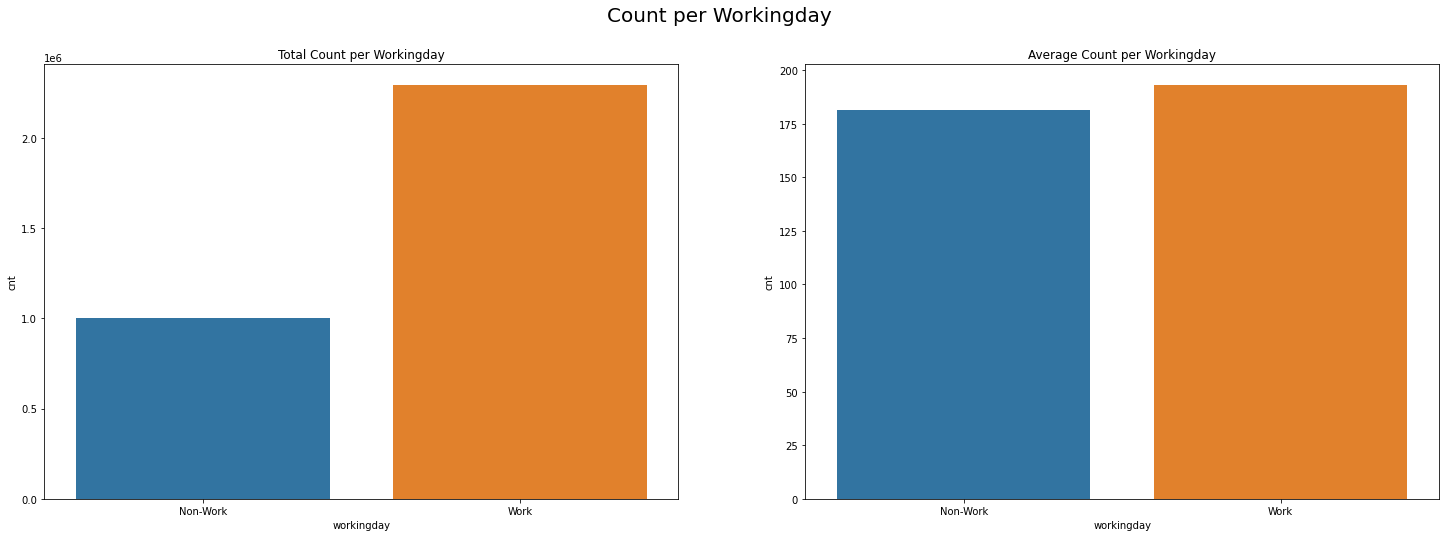

In [42]:
plt.figure(figsize=(25,8))
plt.suptitle('Count per Workingday',fontsize=20)
plt.subplot(1,2,1)
sns.barplot('workingday','cnt', data=df, estimator=sum, ci=0)
plt.title('Total Count per Workingday')
plt.subplot(1,2,2)
sns.barplot('workingday','cnt', data=df, ci=0)
plt.title('Average Count per Workingday')
plt.show()

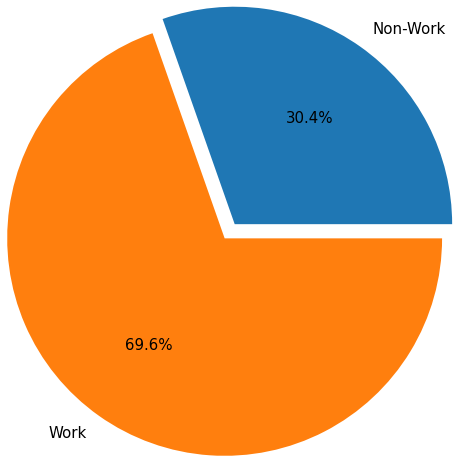

In [154]:
plt.pie(df[['workingday','cnt']].groupby('workingday').sum()['cnt'],
        labels=df['workingday'].unique(), autopct="%1.1f%%", 
        radius=2.5, explode=[0.1,0.1], textprops={'fontsize':15})
plt.show()

### Insight
- Work memiliki Jumlah penyewaan sepeda 2.292.410, lebih banyak dibandingkan Non-Work yang hanya 1.000.269
- Work memiliki Rata-rata penyewaan 193,21 sepeda per jam, lebih tinggi dibandingkan Non-Work dengan rata-rata penyewaan 181,41 sepeda per jam
- Workingday mempengaruhi jumlah Count dilihat dari perbedaan yang cukup siginifikan di Jumlah penyewaan sepeda

In [43]:
df[['weathersit','cnt']].groupby('weathersit').sum()

,cnt
weathersit,
Clear,2338173
Cloudy,795952
Heavy Rain/Snow,223
Light Rain/Snow,158331


In [44]:
df[['weathersit','cnt']].groupby('weathersit').mean()

,cnt
weathersit,
Clear,204.869272
Cloudy,175.165493
Heavy Rain/Snow,74.333333
Light Rain/Snow,111.579281


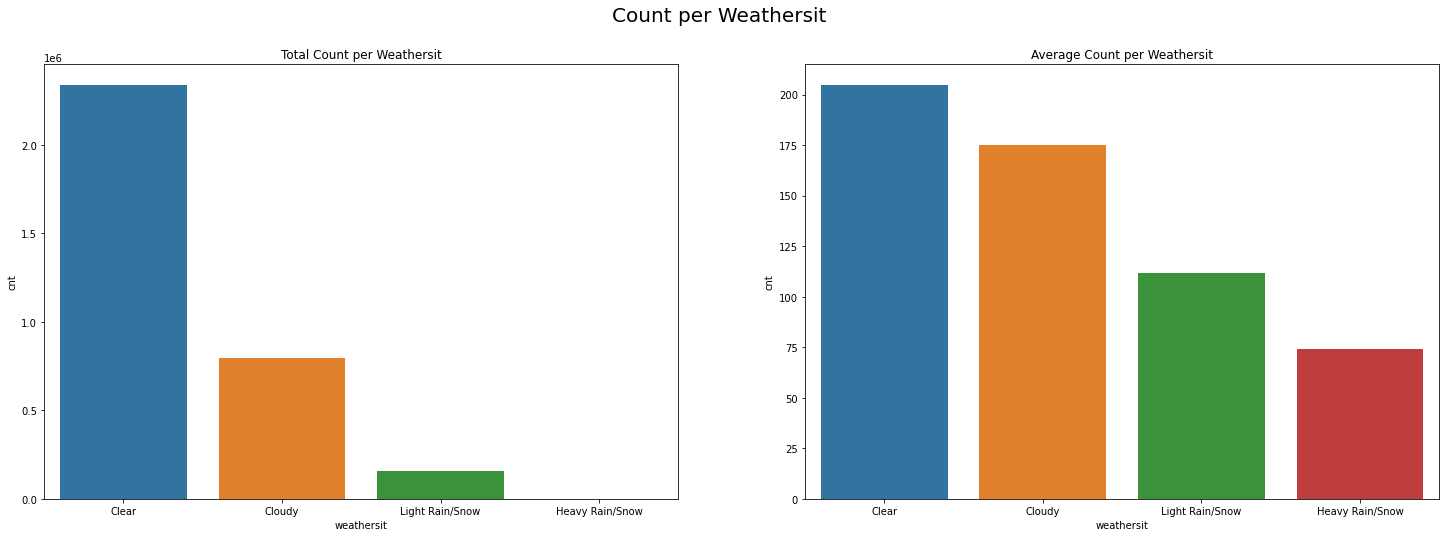

In [45]:
plt.figure(figsize=(25,8))
plt.suptitle('Count per Weathersit',fontsize=20)
plt.subplot(1,2,1)
sns.barplot('weathersit','cnt', data=df, estimator=sum, ci=0)
plt.title('Total Count per Weathersit')
plt.subplot(1,2,2)
sns.barplot('weathersit','cnt', data=df, ci=0)
plt.title('Average Count per Weathersit')
plt.show()

plt.pie(df[['weathersit','cnt']].groupby('weathersit').sum()['cnt'],
        labels=['Clear','Cloudy', 'Heavy Rain/Snow','Light Rain/Snow'], autopct="%1.1f%%", 
        radius=2.5, explode=[0.1,0.1,0.1,0.1], textprops={'fontsize':15})
plt.show()

### Insight
- Weathersit dengan Jumlah penyewaan sepeda Tinggi pada Weathersit Clear dengan jumlah 2.338.173 sepeda
- Weathersit dengan Rata-rata penyewaan sepeda Tinggi pada Weathersit Clear dengan jumlah 204,87 sepeda per jam
- Weathersit mempengaruhi jumlah Count melihat perbedaan jumlah dan rata rata penyewaan sepeda setiap Weathersit

In [46]:
# Re-Categorize temp
temp_bin = [df['temp'].min()-1,10,20,30,df['temp'].max()]
label_temp = ['Cold', 'Cool', 'Warm','Hot']
df['temp_cat'] = pd.cut(df['temp'], bins=temp_bin, labels=label_temp)

Temperature Category
- Cold = <10 derajat celcius
- Cool = 11-20 derajat celcius
- Warm = 21-30 derajat celcius
- Hot = >30 derajat celcius

In [47]:
df[['temp_cat','cnt']].groupby('temp_cat').sum()

,cnt
temp_cat,
Cold,626084
Cool,949036
Warm,1486229
Hot,231330


In [48]:
df[['temp_cat','cnt']].groupby('temp_cat').mean()

,cnt
temp_cat,
Cold,107.704111
Cool,187.704905
Warm,256.202207
Hot,326.276446


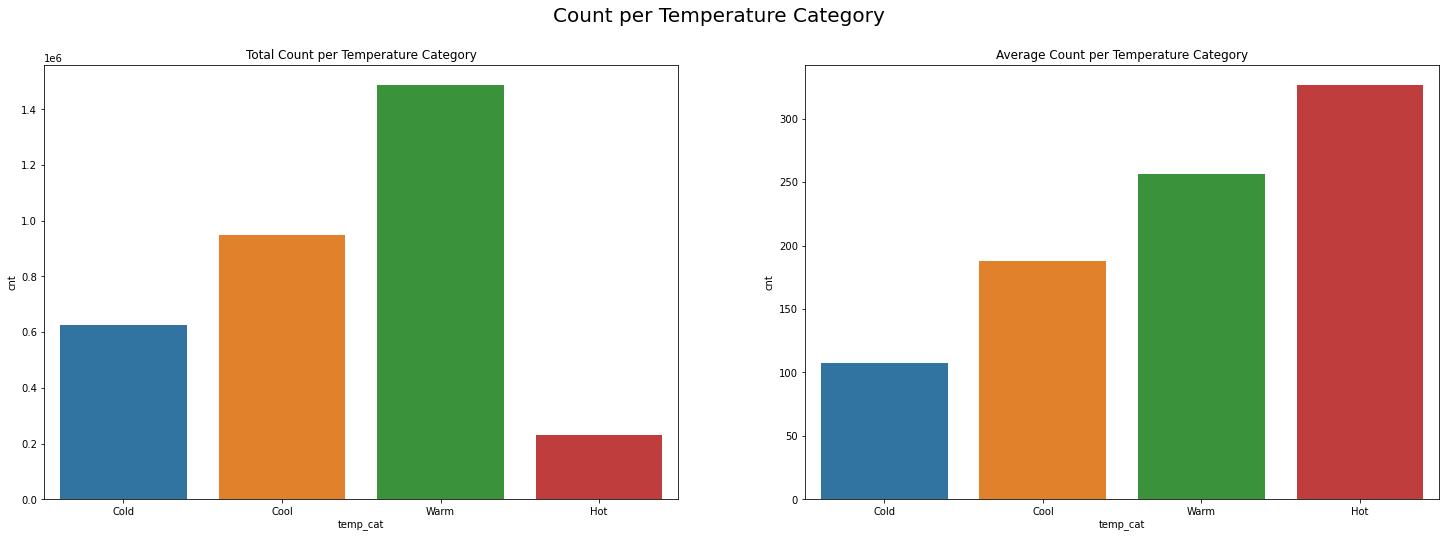

In [49]:
plt.figure(figsize=(25,8))
plt.suptitle('Count per Temperature Category',fontsize=20)
plt.subplot(1,2,1)
sns.barplot('temp_cat','cnt', data=df, estimator=sum, ci=0)
plt.title('Total Count per Temperature Category')
plt.subplot(1,2,2)
sns.barplot('temp_cat','cnt', data=df, ci=0)
plt.title('Average Count per Temperature Category')
plt.show()

plt.pie(df[['temp_cat','cnt']].groupby('temp_cat').sum()['cnt'],
        labels=df['temp_cat'].unique(), autopct="%1.1f%%", 
        radius=2.5, explode=[0.1,0.1,0.1,0.1], textprops={'fontsize':15})
plt.show()

### Insight
- Temp dengan Jumlah penyewaan sepeda Tinggi pada Temp Warm (21-30 derajat celcius) dengan jumlah 1.486.229 sepeda
- Temp dengan Rata-rata penyewaan sepeda Tinggi pada Temp Hot (>30 derajat celcius) dengan jumlah 326.28 sepeda per jam
- Temp mempengaruhi jumlah Count melihat perbedaan jumlah dan rata rata penyewaan sepeda setiap Temp Category

In [50]:
# Re-Categorize atemp
atemp_bin = [df['atemp'].min()-1,10,20,30,40,df['atemp'].max()]
label_atemp = ['Cold', 'Cool', 'Warm','Hot','Extreme']
df['atemp_cat'] = pd.cut(df['atemp'], bins=atemp_bin, labels=label_atemp)

Feels-Like-Temperature Category
- Cold = <10 derajat celcius
- Cool = 11-20 derajat celcius
- Warm = 21-30 derajat celcius
- Hot = 31-40 derajat celcius
- Extreme = >40 derajat celcius

In [51]:
df[['atemp_cat','cnt']].groupby('atemp_cat').sum()

,cnt
atemp_cat,
Cold,633232
Cool,974836
Warm,1263879
Hot,402955
Extreme,17777


In [52]:
df[['atemp_cat','cnt']].groupby('atemp_cat').mean()

,cnt
atemp_cat,
Cold,108.485866
Cool,183.550367
Warm,258.250715
Hot,317.537431
Extreme,261.426471


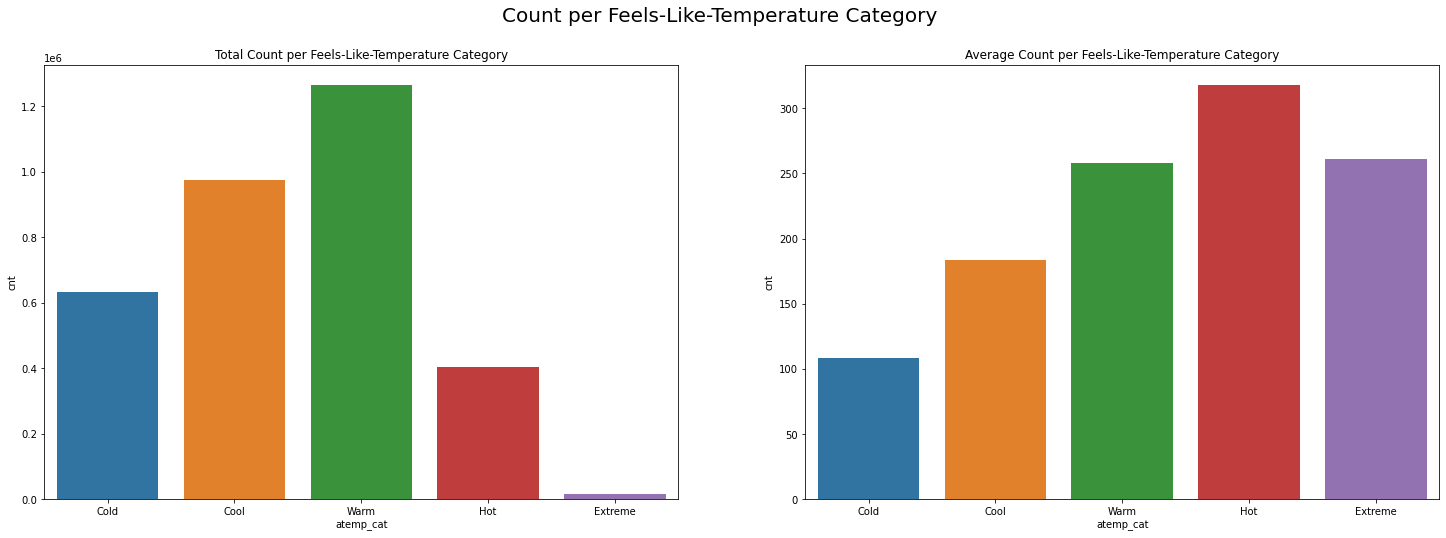

In [53]:
plt.figure(figsize=(25,8))
plt.suptitle('Count per Feels-Like-Temperature Category',fontsize=20)
plt.subplot(1,2,1)
sns.barplot('atemp_cat','cnt', data=df, estimator=sum, ci=0)
plt.title('Total Count per Feels-Like-Temperature Category')
plt.subplot(1,2,2)
sns.barplot('atemp_cat','cnt', data=df, ci=0)
plt.title('Average Count per Feels-Like-Temperature Category')
plt.show()

plt.pie(df[['atemp_cat','cnt']].groupby('atemp_cat').sum()['cnt'],
        labels=df['atemp_cat'].unique(), autopct="%1.1f%%", 
        radius=2.5, explode=[0.1,0.1,0.1,0.1,0.1], textprops={'fontsize':15})
plt.show()

### Insight
- atemp dengan Jumlah penyewaan sepeda Tinggi pada atemp Warm (21-30 derajat celcius) dengan jumlah 1.263.879 sepeda
- atemp dengan Rata-rata penyewaan sepeda Tinggi pada atemp Hot (31-40 derajat celcius) dengan jumlah 317.54 sepeda per jam
- atemp mempengaruhi jumlah Count melihat perbedaan jumlah dan rata rata penyewaan sepeda setiap atemp category

In [54]:
# Re-Categorize hum
hum_bin = [df['hum'].min()-1,30,60,df['hum'].max()]
label_hum = ['Too Dry', 'Optimum', 'Too Moist']
df['hum_cat'] = pd.cut(df['hum'], bins=hum_bin, labels=label_hum)

Humidity Category
- Too Dry = 0-30 %
- Optimum = 31-60 %
- Too Moist = 61-100 %

In [55]:
df[['hum_cat','cnt']].groupby('hum_cat').sum()

,cnt
hum_cat,
Too Dry,223391
Optimum,1704740
Too Moist,1364548


In [56]:
df[['hum_cat','cnt']].groupby('hum_cat').mean()

,cnt
hum_cat,
Too Dry,288.618863
Optimum,236.572301
Too Moist,145.180126


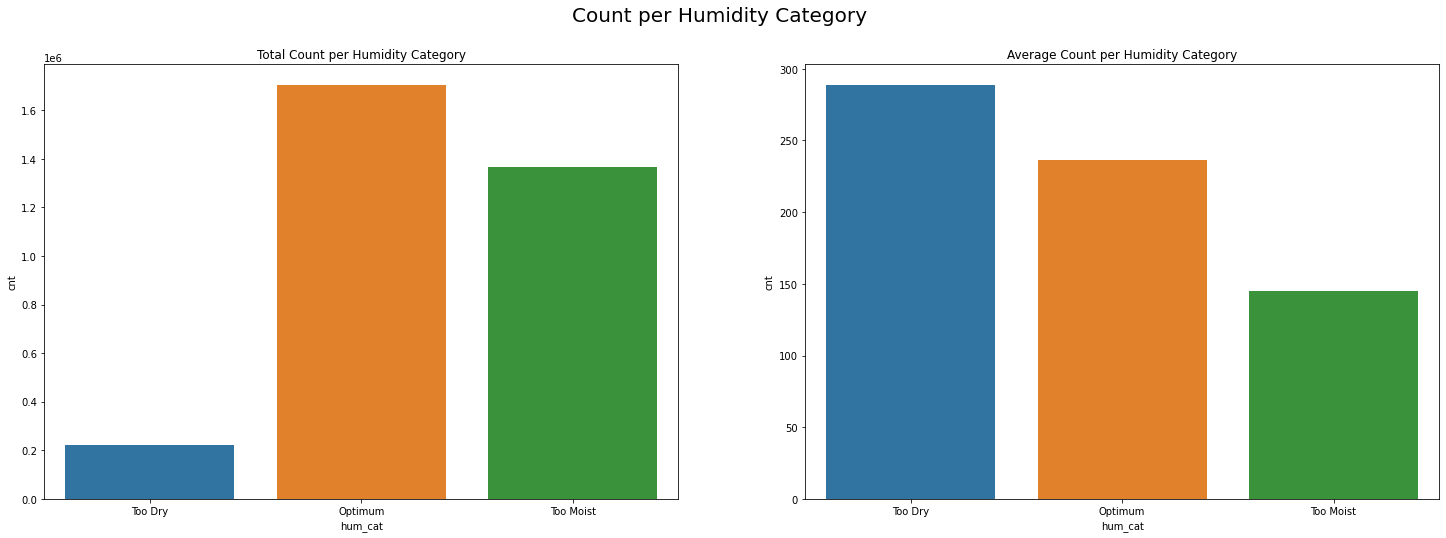

In [57]:
plt.figure(figsize=(25,8))
plt.suptitle('Count per Humidity Category',fontsize=20)
plt.subplot(1,2,1)
sns.barplot('hum_cat','cnt', data=df, estimator=sum, ci=0)
plt.title('Total Count per Humidity Category')
plt.subplot(1,2,2)
sns.barplot('hum_cat','cnt', data=df, ci=0)
plt.title('Average Count per Humidity Category')
plt.show()

plt.pie(df[['hum_cat','cnt']].groupby('hum_cat').sum()['cnt'],
        labels=df['hum_cat'].unique(), autopct="%1.1f%%", 
        radius=2.5, explode=[0.1,0.1,0.1], textprops={'fontsize':15})
plt.show()

### Insight
- Humidity dengan Jumlah penyewaan sepeda Tinggi pada Humidity Optimum (31-60 %) dengan jumlah 1.704.740 sepeda
- Humidity dengan Rata-rata penyewaan sepeda Tinggi pada Humidity Too Dry (0-30 %) dengan jumlah 288,61 sepeda per jam
- Humidity mempengaruhi jumlah Count melihat perbedaan jumlah dan rata rata penyewaan sepeda setiap Humidity Category

In [58]:
# Re-Categorize windspeed
wind_bin = [df['windspeed'].min()-1,20,40,df['windspeed'].max()]
label_wind = ['Slow Wind', 'Normal', 'Strong Wind']
df['wind_cat'] = pd.cut(df['windspeed'], bins=wind_bin, labels=label_wind)

Windspeed Category
- Slow Wind = 0-20 km/h
- Normal = 21-40 km/h
- Strong Wind = >40 km/h

In [59]:
df[['wind_cat','cnt']].groupby('wind_cat').sum()

,cnt
wind_cat,
Slow Wind,2801870
Normal,480970
Strong Wind,9839


In [60]:
df[['wind_cat','cnt']].groupby('wind_cat').mean()

,cnt
wind_cat,
Slow Wind,187.090678
Normal,205.542735
Strong Wind,156.174603


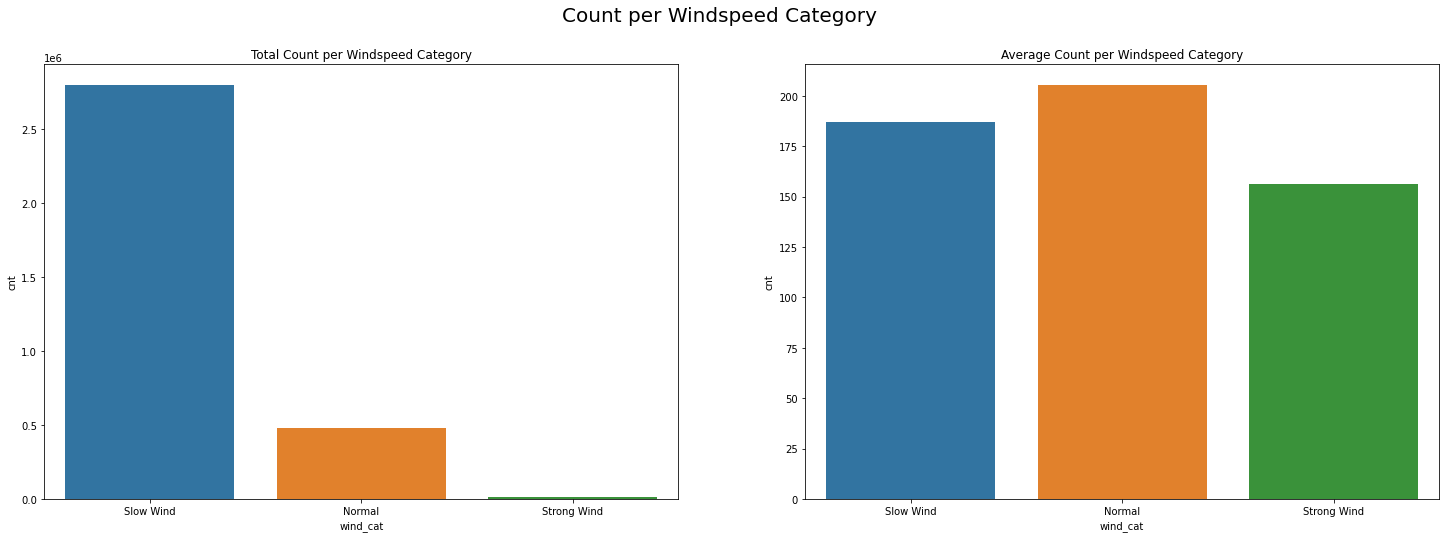

In [61]:
plt.figure(figsize=(25,8))
plt.suptitle('Count per Windspeed Category',fontsize=20)
plt.subplot(1,2,1)
sns.barplot('wind_cat','cnt', data=df, estimator=sum, ci=0)
plt.title('Total Count per Windspeed Category')
plt.subplot(1,2,2)
sns.barplot('wind_cat','cnt', data=df, ci=0)
plt.title('Average Count per Windspeed Category')
plt.show()

plt.pie(df[['wind_cat','cnt']].groupby('wind_cat').sum()['cnt'],
        labels=df['wind_cat'].unique(), autopct="%1.1f%%", 
        radius=2.5, explode=[0.1,0.1,0.1], textprops={'fontsize':15})
plt.show()

### Insight
- Windspeed dengan Jumlah penyewaan sepeda Tinggi pada Windspeed Slow Wind (0-20 km/h) dengan jumlah 2.801.870 sepeda
- Windspeed dengan Rata-rata penyewaan sepeda Tinggi pada Windspeed Normal (21-40 km/h) dengan jumlah 205,54 sepeda per jam
- Windspeed mempengaruhi jumlah Count melihat perbedaan jumlah dan rata rata penyewaan sepeda setiap Windspeed Category

In [62]:
df[['event','cnt']].groupby('event').sum()

,cnt
event,
No,2914311
Yes,378368


In [63]:
df[['event','cnt']].groupby('event').mean()

,cnt
event,
No,172.710146
Yes,749.243564


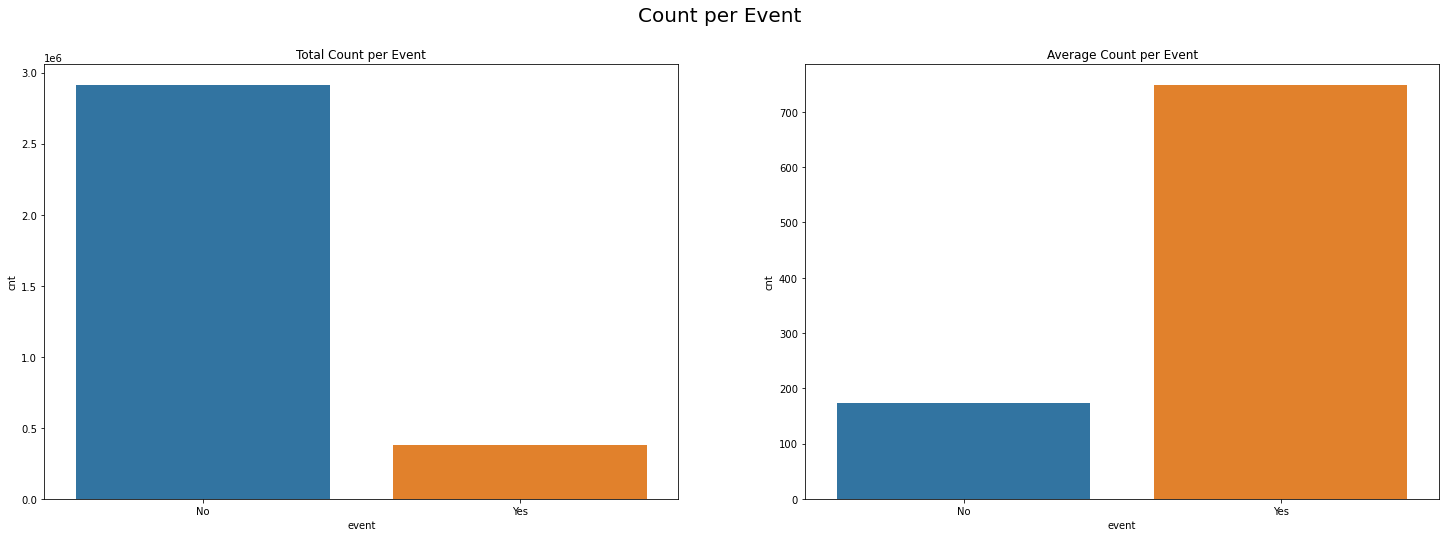

In [64]:
plt.figure(figsize=(25,8))
plt.suptitle('Count per Event',fontsize=20)
plt.subplot(1,2,1)
sns.barplot('event','cnt', data=df, estimator=sum, ci=0)
plt.title('Total Count per Event')
plt.subplot(1,2,2)
sns.barplot('event','cnt', data=df, ci=0)
plt.title('Average Count per Event')
plt.show()

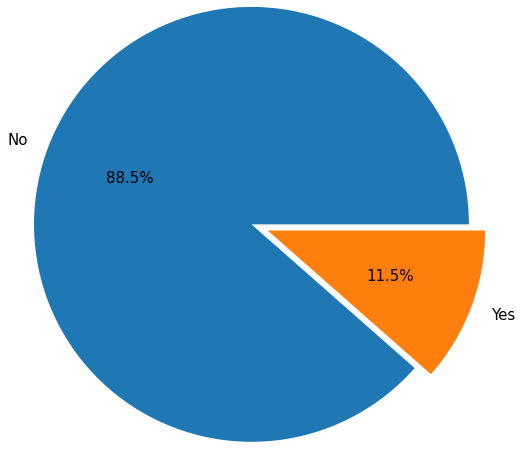

In [160]:
plt.pie(df[['event','cnt']].groupby('event').sum()['cnt'],
        labels=df['event'].unique(), autopct="%1.1f%%", 
        radius=2.5, explode=[0.1,0.1], textprops={'fontsize':15})
plt.show()

### Insight
- Event (No) memiliki Jumlah penyewaan sepeda 2.914.311, lebih banyak dibandingkan Event (Yes) yang hanya 378.368
- Event (Yes) memiliki Rata-rata penyewaan 749,24 sepeda per jam, lebih tinggi dibandingkan Event (No) dengan rata-rata penyewaan 172,71 sepeda per jam
- Event mempengaruhi jumlah Count dilihat dari perbedaan yang cukup siginifikan di Jumlah dan rata-rata penyewaan sepeda

### Multivariate Analysis

In [65]:
pd.crosstab(index=df['season'], columns=df['hr'], values=df['cnt'], aggfunc='sum', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
season,,,,,,,,,,,,,,,,,,,,,,,,,
Fall,9971,6322,4159,2052,1279,3976,14376,40763,69757,42142,32994,39841,49573,49066,47084,49528,61402,86050,75428,52575,37549,28555,21871,15300,841613
Spring,10459,6481,4302,2084,1118,3508,14549,40753,69945,43053,34919,42585,51252,52022,48903,51382,63831,95468,88904,65994,47285,35246,26885,17661,918589
Summer,13822,8132,5716,2930,1541,4947,18946,52000,79204,47927,40405,47319,56458,55656,53060,54221,69516,107562,102330,78383,58505,45147,34416,22986,1061129
Winter,4878,3229,2175,1108,490,1830,7261,20655,42095,26316,17939,21575,27131,28175,26605,28018,32999,47780,43110,29837,21211,16497,12440,7994,471348
All,39130,24164,16352,8174,4428,14261,55132,154171,261001,159438,126257,151320,184414,184919,175652,183149,227748,336860,309772,226789,164550,125445,95612,63941,3292679


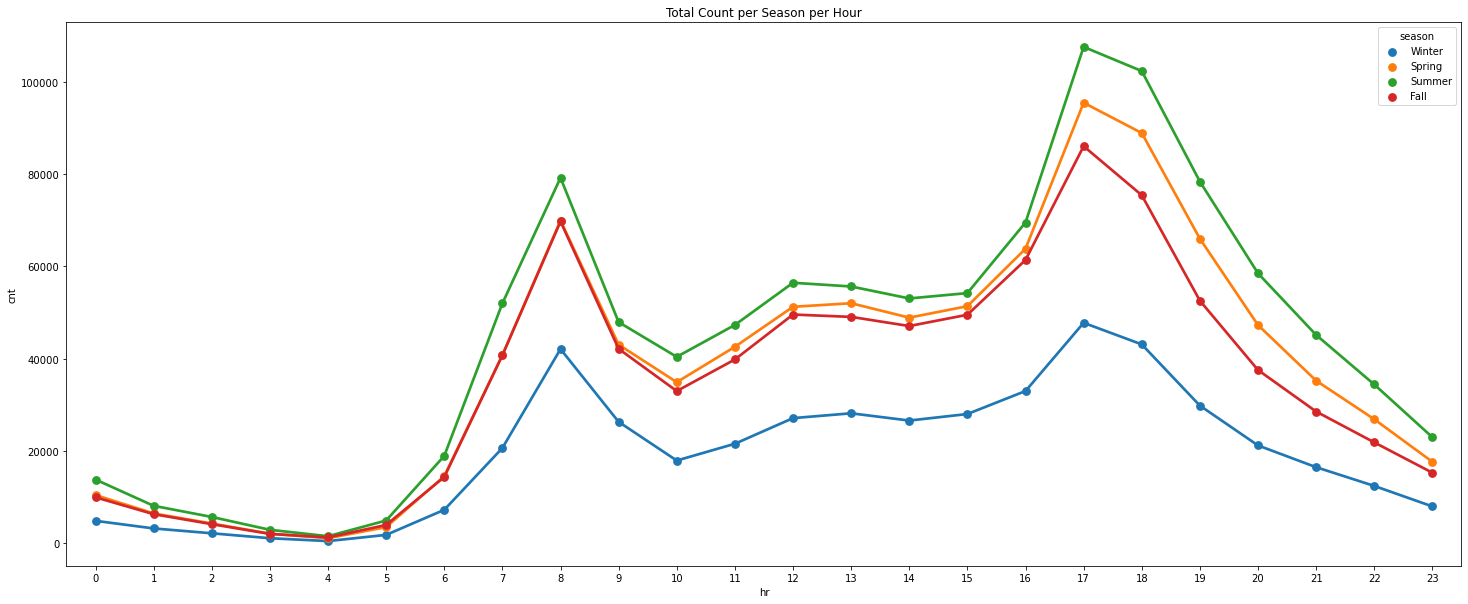

In [66]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='season', ci=0, estimator=sum)
plt.title('Total Count per Season per Hour')
plt.show()

In [67]:
pd.crosstab(index=df['season'], columns=df['hr'], values=df['cnt'], aggfunc='mean', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
season,,,,,,,,,,,,,,,,,,,,,,,,,
Fall,56.333333,35.920455,23.765714,11.861272,7.267045,22.590909,81.681818,231.607955,396.346591,239.443182,187.465909,226.369318,281.664773,277.209040,266.011299,279.819209,346.903955,486.158192,426.146893,297.033898,212.141243,161.327684,123.564972,86.440678,198.868856
Spring,56.842391,35.222826,23.380435,11.450549,6.211111,19.169399,79.070652,221.483696,380.135870,233.983696,189.777174,231.440217,278.543478,282.728261,265.777174,279.250000,346.907609,518.847826,483.173913,358.663043,256.983696,191.554348,146.114130,95.983696,208.344069
Summer,73.914439,43.720430,30.731183,15.752688,8.240642,26.454545,101.315508,276.595745,421.297872,254.930851,214.920213,251.696809,300.308511,296.042553,282.234043,288.409574,369.765957,572.138298,547.219251,419.160428,312.860963,241.427807,184.042781,122.919786,236.016237
Winter,27.404494,18.140449,12.794118,7.102564,3.181818,10.701754,40.792135,115.391061,235.167598,147.016760,100.217877,120.530726,150.727778,156.527778,147.805556,155.655556,182.314917,263.977901,239.500000,165.761111,117.838889,91.650000,69.111111,44.411111,111.114569
All,53.898072,33.375691,22.869930,11.727403,6.352941,19.889819,76.044138,212.064649,359.011004,219.309491,173.668501,208.143054,253.315934,253.661180,240.949246,251.233196,311.983562,461.452055,425.510989,311.523352,226.030220,172.314560,131.335165,87.831044,189.463088


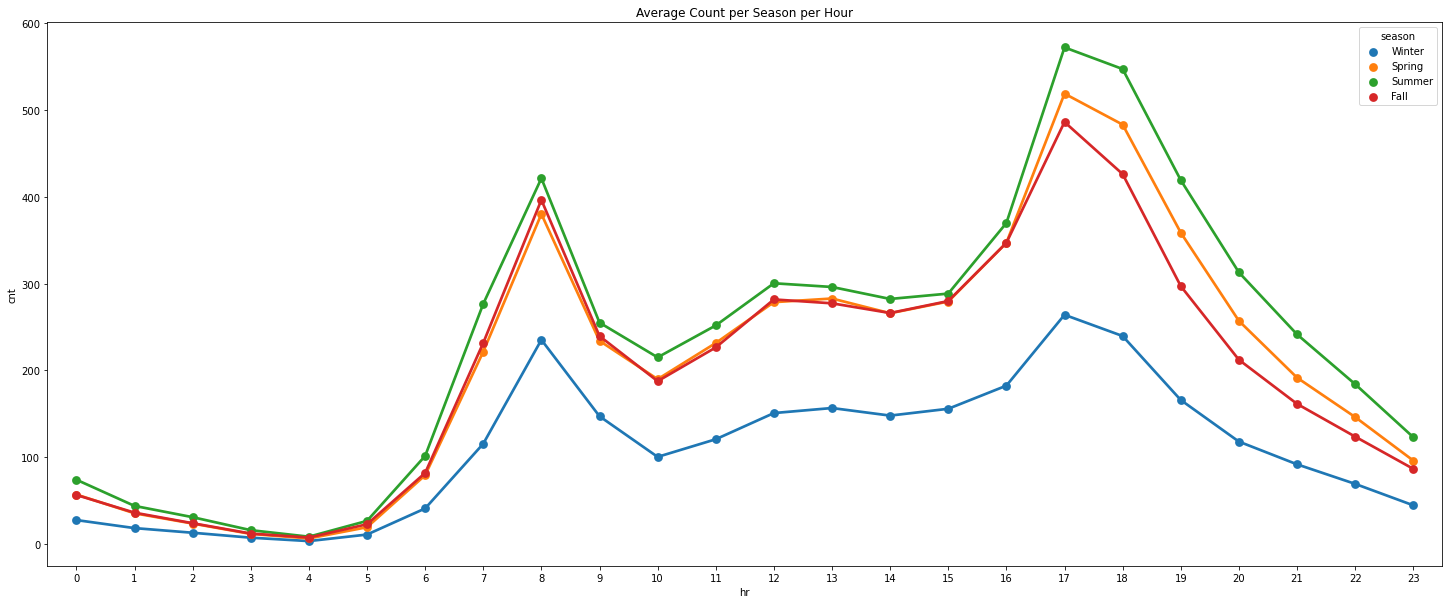

In [68]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='season', ci=0)
plt.title('Average Count per Season per Hour')
plt.show()

### Insight
- Total dan rata-rata penyewaan sepeda pada season Winter memiliki jumlah paling kecil untuk setiap jam.
- Total dan rata-rata penyewaan sepeda pada season Summer memiliki jumlah paling besar untuk setiap jam.
- Untuk season Spring dan Fall perbedaan total dan rata-rata penyewaan sepeda tidak berbeda jauh.

In [69]:
pd.crosstab(index=df['yr'], columns=df['hr'], values=df['cnt'], aggfunc='sum', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
yr,,,,,,,,,,,,,,,,,,,,,,,,,
2011,15540,9558,6661,3441,1817,5157,20801,56930,95467,59486,47511,56598,69198,69339,66482,68590,85622,127632,116985,85802,62818,48875,37677,25116,1243103
2012,23590,14606,9691,4733,2611,9104,34331,97241,165534,99952,78746,94722,115216,115580,109170,114559,142126,209228,192787,140987,101732,76570,57935,38825,2049576
All,39130,24164,16352,8174,4428,14261,55132,154171,261001,159438,126257,151320,184414,184919,175652,183149,227748,336860,309772,226789,164550,125445,95612,63941,3292679


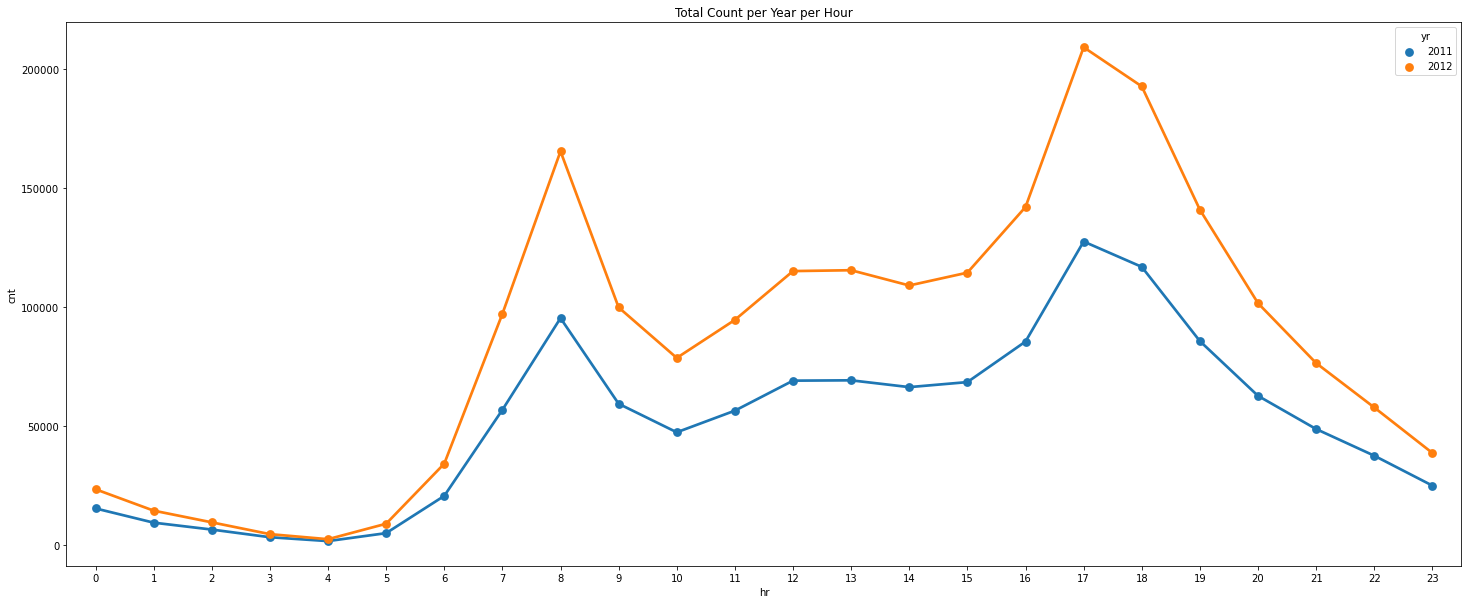

In [70]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='yr', ci=0, estimator=sum)
plt.title('Total Count per Year per Hour')
plt.show()

In [71]:
pd.crosstab(index=df['yr'], columns=df['hr'], values=df['cnt'], aggfunc='mean', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
yr,,,,,,,,,,,,,,,,,,,,,,,,,
2011,43.047091,26.550000,18.923295,10.061404,5.391691,14.609065,57.620499,156.831956,262.994490,163.873278,130.884298,155.917355,190.104396,190.491758,182.642857,188.434066,234.580822,349.676712,322.272727,236.369146,173.052342,134.641873,103.793388,69.190083,143.794448
2012,64.630137,40.126374,26.696970,13.332394,7.252778,25.010989,94.315934,267.145604,454.763736,274.593407,216.335165,260.225275,316.527473,316.657534,299.095890,313.860274,389.386301,573.227397,528.183562,386.265753,278.717808,209.780822,158.726027,106.369863,234.666361
All,53.898072,33.375691,22.869930,11.727403,6.352941,19.889819,76.044138,212.064649,359.011004,219.309491,173.668501,208.143054,253.315934,253.661180,240.949246,251.233196,311.983562,461.452055,425.510989,311.523352,226.030220,172.314560,131.335165,87.831044,189.463088


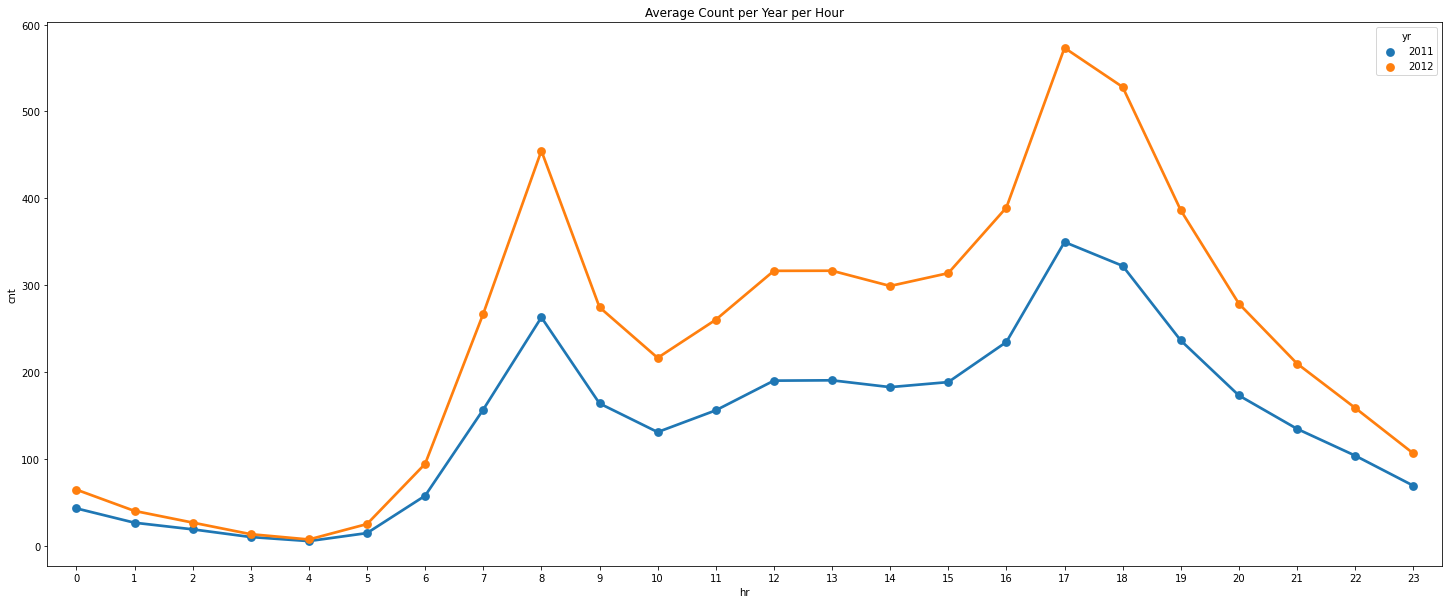

In [72]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='yr', ci=0)
plt.title('Average Count per Year per Hour')
plt.show()

In [73]:
pd.crosstab(index=df['mnth'], columns=df['hr'], values=df['cnt'], aggfunc='sum', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
mnth,,,,,,,,,,,,,,,,,,,,,,,,,
April,2659,1612,1208,588,289,927,3942,11544,20995,13075,10480,12645,15211,15482,15304,15784,19175,28691,26305,19077,12716,9555,7127,4703,269094
August,4178,2424,1653,833,493,1596,6290,17600,27082,16253,13091,15089,18596,17994,17187,17721,23067,36675,35103,26200,19036,14541,11069,7423,351194
December,2470,1683,1187,537,320,1038,3551,10097,18970,11832,8334,10332,12887,12919,12329,12945,15238,19624,17673,12437,8805,6935,5169,3724,211036
February,1635,945,658,308,111,565,2390,7289,14498,8638,5543,6574,8450,8683,7913,8464,10238,15532,13829,9499,6926,5627,4316,2721,151352
January,1462,1029,763,383,162,589,2148,5808,12442,7531,5072,5889,7451,7856,7318,7831,9379,13676,12283,8978,6354,4689,3510,2330,134933
July,5177,2997,2130,1042,500,1592,6111,16365,25368,15589,13197,15398,17805,17591,16952,17006,21921,33571,32344,25649,20281,15990,12217,8155,344948
June,4222,2595,1658,806,530,1512,6234,17131,26090,15766,12856,15308,18398,18186,17276,17481,22933,35347,32864,25418,19910,15081,11285,7455,346342
March,2160,1525,871,487,228,844,3459,9886,19462,12057,8443,10255,12939,13274,12582,13202,15664,24322,23026,15787,10722,8069,5981,3675,228920
May,4134,2530,1673,807,424,1241,5194,14260,24187,14858,12774,15787,18826,19321,17381,18763,23339,34058,31899,23685,17226,12807,9962,6550,331686


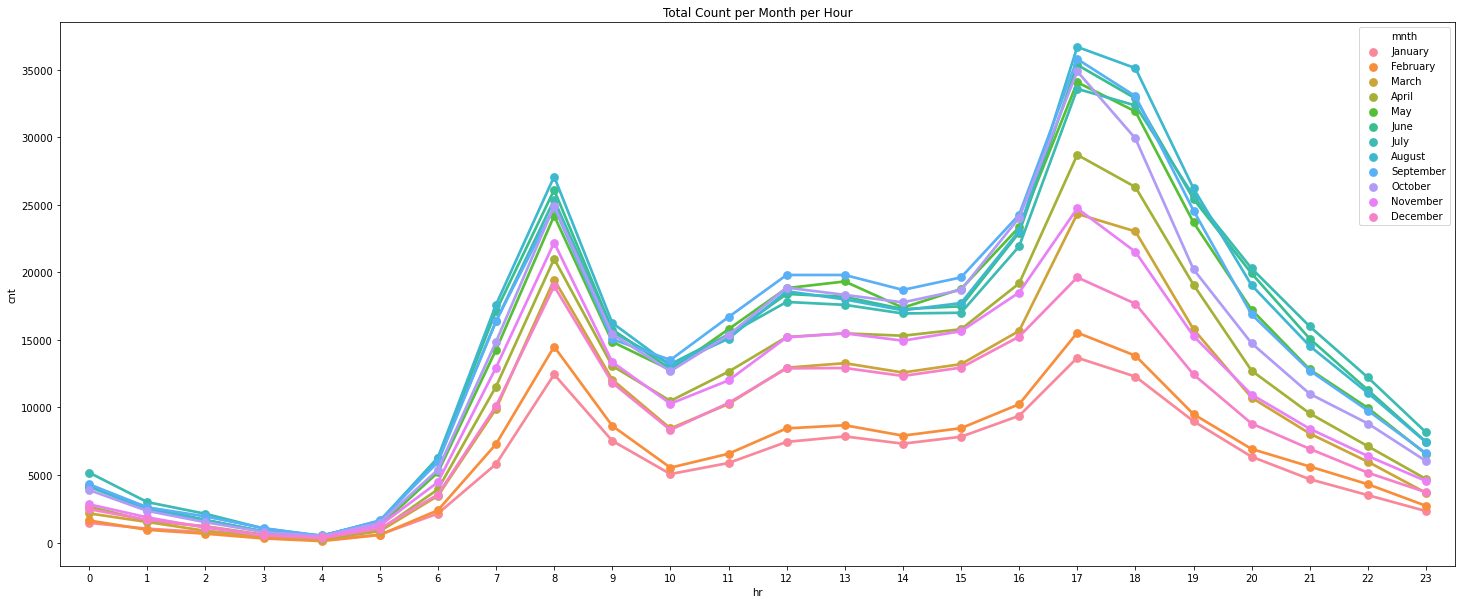

In [74]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='mnth', ci=0, estimator=sum)
plt.title('Total Count per Month per Hour')
plt.show()

In [75]:
pd.crosstab(index=df['mnth'], columns=df['hr'], values=df['cnt'], aggfunc='mean', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
mnth,,,,,,,,,,,,,,,,,,,,,,,,,
April,44.316667,26.866667,20.133333,10.137931,4.898305,15.450000,65.700000,192.400000,349.916667,217.916667,174.666667,210.750000,253.516667,258.033333,255.066667,263.066667,319.583333,478.183333,438.416667,317.950000,211.933333,159.250000,118.783333,78.383333,187.260960
August,68.491803,39.737705,27.098361,13.655738,8.081967,26.163934,103.114754,283.870968,436.806452,262.145161,211.145161,243.370968,299.935484,290.225806,277.209677,285.822581,372.048387,591.532258,575.459016,429.508197,312.065574,238.377049,181.459016,121.688525,238.097627
December,39.838710,27.145161,19.145161,8.950000,5.423729,16.741935,57.274194,162.854839,305.967742,190.838710,134.419355,166.645161,207.854839,208.370968,198.854839,208.790323,245.774194,316.516129,285.048387,200.596774,142.016129,111.854839,83.370968,60.064516,142.303439
February,29.196429,16.875000,12.185185,6.039216,2.466667,10.660377,41.929825,127.877193,254.350877,151.543860,97.245614,115.333333,148.245614,152.333333,138.824561,148.491228,179.614035,272.491228,242.614035,166.649123,121.508772,98.719298,75.719298,47.736842,112.865026
January,24.366667,17.150000,13.155172,8.148936,3.000000,10.333333,36.406780,96.800000,207.366667,125.516667,84.533333,98.150000,122.147541,128.786885,119.967213,128.377049,151.274194,220.580645,201.360656,147.180328,104.163934,76.868852,57.540984,38.196721,94.424773
July,83.500000,48.338710,34.354839,16.806452,8.064516,25.677419,98.564516,263.951613,409.161290,251.435484,212.854839,248.354839,287.177419,283.725806,273.419355,274.290323,353.564516,541.467742,521.677419,413.693548,327.112903,257.903226,197.048387,131.532258,231.819892
June,70.366667,43.250000,27.633333,13.433333,8.833333,25.200000,103.900000,285.516667,434.833333,262.766667,214.266667,255.133333,306.633333,303.100000,287.933333,291.350000,382.216667,589.116667,547.733333,423.633333,331.833333,251.350000,188.083333,124.250000,240.515278
March,34.838710,24.596774,15.017241,8.116667,4.145455,14.066667,55.790323,159.451613,313.903226,194.467742,136.177419,165.403226,208.693548,214.096774,202.935484,212.935484,252.645161,392.290323,371.387097,254.629032,172.935484,130.145161,96.467742,59.274194,155.410726
May,66.677419,40.806452,26.983871,13.016129,6.838710,20.016129,83.774194,230.000000,390.112903,239.645161,206.032258,254.629032,303.645161,311.629032,280.338710,302.629032,376.435484,549.322581,514.500000,382.016129,277.838710,206.564516,160.677419,105.645161,222.907258


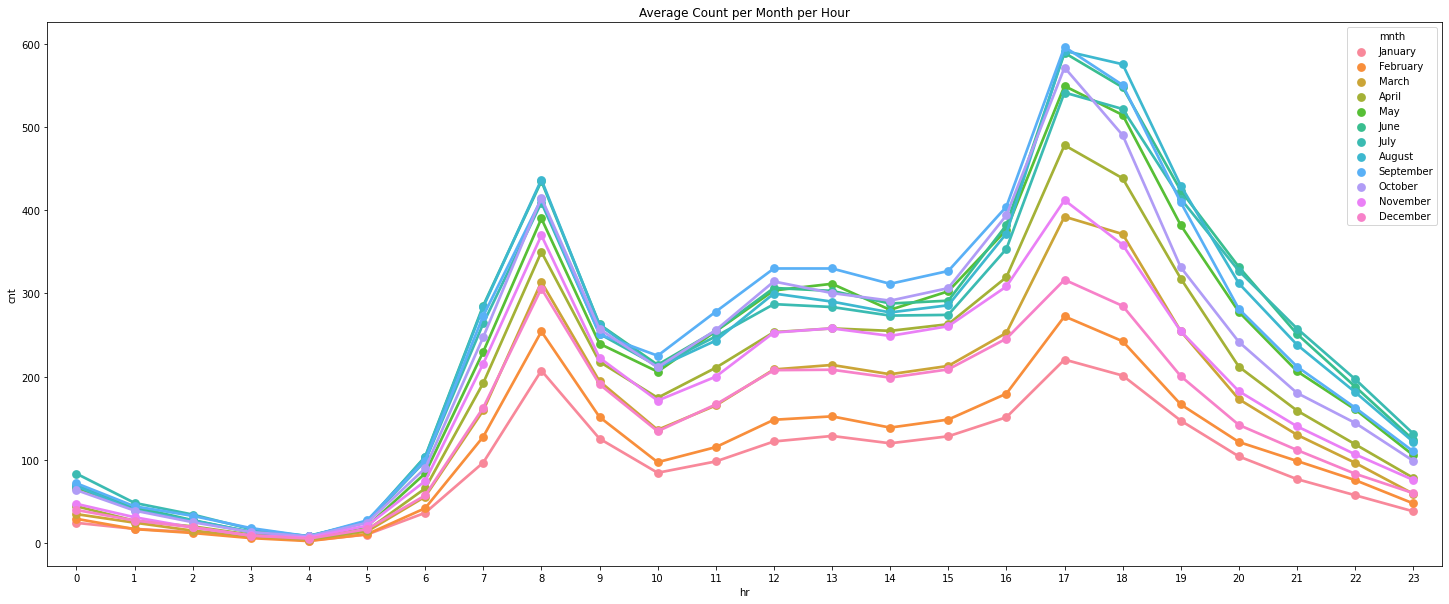

In [76]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='mnth', ci=0)
plt.title('Average Count per Month per Hour')
plt.show()

In [77]:
pd.crosstab(index=df['holiday'], columns=df['hr'], values=df['cnt'], aggfunc='sum', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
holiday,,,,,,,,,,,,,,,,,,,,,,,,,
Holiday,1207,817,535,209,117,223,594,1725,3581,3595,4273,5219,6030,6269,6012,5568,5718,6156,5644,4657,3737,3047,2286,1216,78435
Non-Holiday,37923,23347,15817,7965,4311,14038,54538,152446,257420,155843,121984,146101,178384,178650,169640,177581,222030,330704,304128,222132,160813,122398,93326,62725,3214244
All,39130,24164,16352,8174,4428,14261,55132,154171,261001,159438,126257,151320,184414,184919,175652,183149,227748,336860,309772,226789,164550,125445,95612,63941,3292679


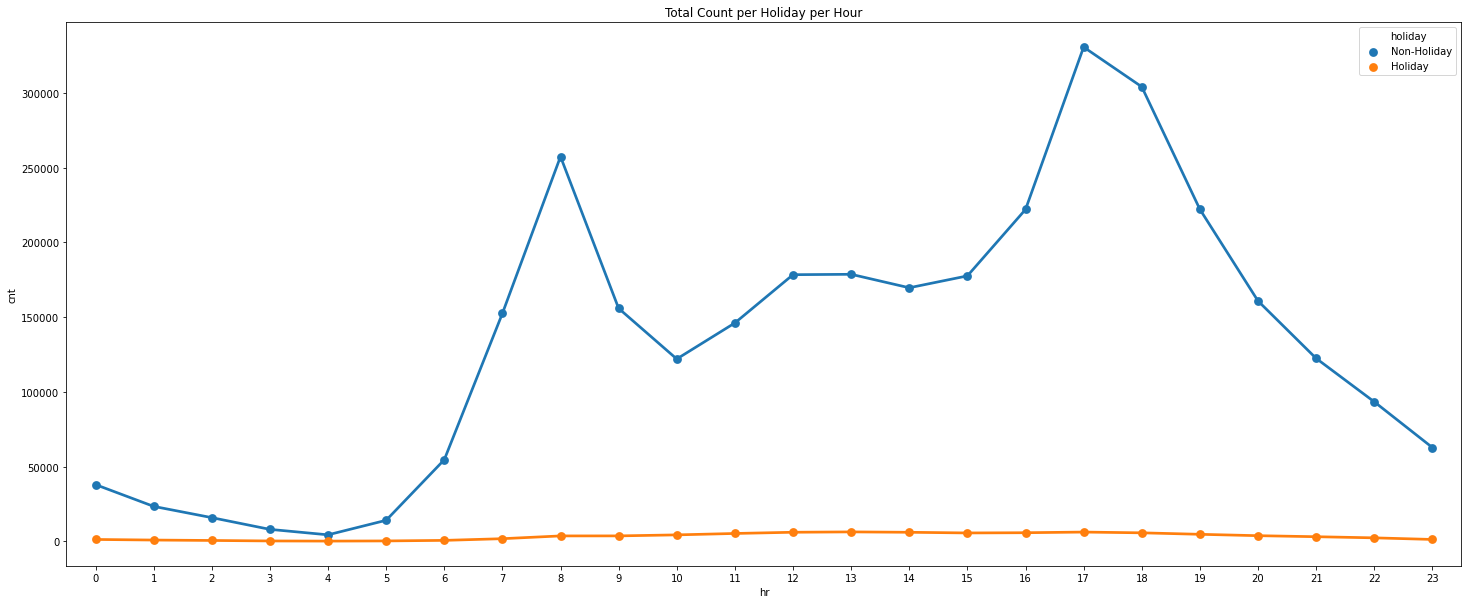

In [78]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='holiday', ci=0, estimator=sum)
plt.title('Total Count per Holiday per Hour')
plt.show()

In [79]:
pd.crosstab(index=df['holiday'], columns=df['hr'], values=df['cnt'], aggfunc='mean', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
holiday,,,,,,,,,,,,,,,,,,,,,,,,,
Holiday,57.476190,38.904762,25.476190,11.611111,5.850000,10.619048,28.285714,82.142857,170.523810,171.190476,203.476190,248.523810,287.142857,298.523810,286.285714,265.142857,272.285714,293.142857,268.761905,221.761905,177.952381,145.095238,108.857143,57.904762,156.870000
Non-Holiday,53.791489,33.210526,22.791066,11.730486,6.367799,20.169540,77.468750,215.929178,364.617564,220.740793,172.781870,206.941926,252.311174,252.330508,239.604520,250.820621,313.159379,466.437236,430.166902,314.189533,227.458274,173.123055,132.002829,88.719943,190.428580
All,53.898072,33.375691,22.869930,11.727403,6.352941,19.889819,76.044138,212.064649,359.011004,219.309491,173.668501,208.143054,253.315934,253.661180,240.949246,251.233196,311.983562,461.452055,425.510989,311.523352,226.030220,172.314560,131.335165,87.831044,189.463088


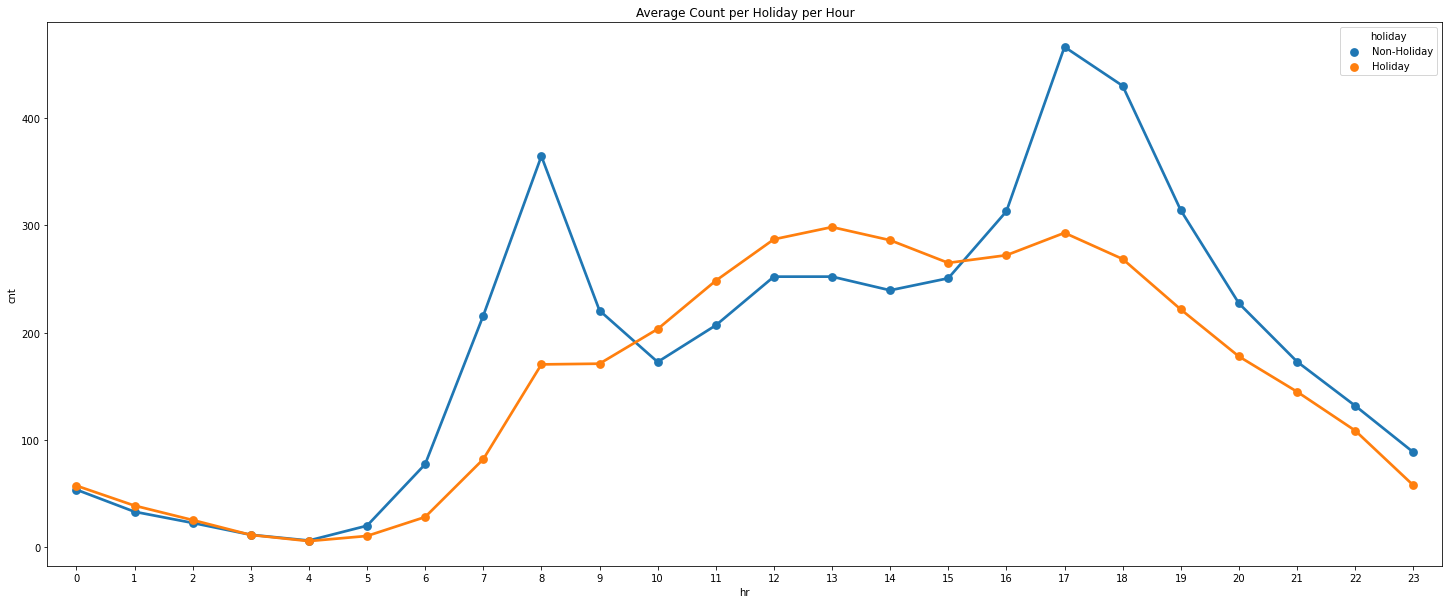

In [80]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='holiday', ci=0)
plt.title('Average Count per Holiday per Hour')
plt.show()

### Insight
- Total penyewaan sepeda per jam untuk Holiday cenderung kecil dan konstan.
- Rata-rata penyewaan sepeda tertinggi per jam untuk Holiday ada di jam 13.

In [81]:
pd.crosstab(index=df['weekday'], columns=df['hr'], values=df['cnt'], aggfunc='sum', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
weekday,,,,,,,,,,,,,,,,,,,,,,,,,
Friday,5453,2571,1325,673,589,2486,9363,26450,48077,26935,16404,19564,24715,25113,23854,26256,34423,51211,43783,31415,22186,17667,15295,11982,487790
Monday,3571,1800,1021,496,567,2252,8930,25848,42868,22718,14459,17024,21581,21384,20041,21046,29583,52249,50060,35836,25176,18152,12039,6802,455503
Saturday,9902,7117,5302,2403,804,854,2205,4826,12020,19613,27691,34504,39415,40464,40040,40155,38445,35113,30373,24953,18810,16224,14525,12049,477807
Sunday,9775,8053,6286,3239,955,852,1493,3476,8805,16437,27151,33115,39161,39368,38181,37163,37317,33471,28626,23675,17643,13403,9883,6499,444027
Thursday,4045,1774,934,497,528,2669,11066,31388,50323,24810,13654,16360,20550,20233,18289,20237,29775,54844,52218,37279,27967,20580,15313,10062,485395
Tuesday,2790,1254,687,382,508,2470,10863,30569,48122,24118,13181,14924,18826,19031,17510,19438,29817,56605,53827,36808,26332,19368,13757,7922,469109
Wednesday,3594,1595,797,484,477,2678,11212,31614,50786,24807,13717,15829,20166,19326,17737,18854,28388,53367,50885,36823,26436,20051,14800,8625,473048
All,39130,24164,16352,8174,4428,14261,55132,154171,261001,159438,126257,151320,184414,184919,175652,183149,227748,336860,309772,226789,164550,125445,95612,63941,3292679


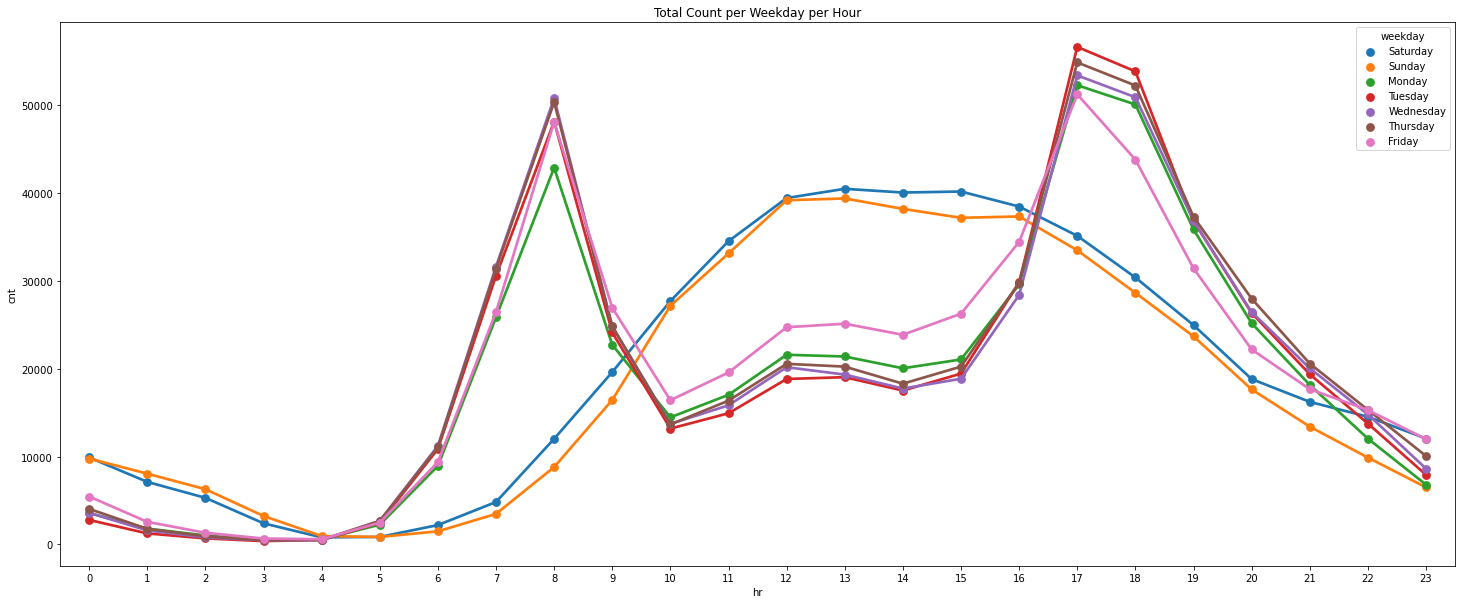

In [82]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='weekday', ci=0, estimator=sum)
plt.title('Total Count per Weekday per Hour')
plt.show()

In [83]:
pd.crosstab(index=df['weekday'], columns=df['hr'], values=df['cnt'], aggfunc='mean', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
weekday,,,,,,,,,,,,,,,,,,,,,,,,,
Friday,52.432692,24.721154,12.740385,6.598039,6.072165,23.903846,90.028846,254.326923,462.278846,258.990385,157.730769,188.115385,237.644231,241.471154,229.365385,252.461538,330.990385,492.413462,420.990385,302.067308,213.326923,169.875000,147.067308,115.211538,196.135907
Monday,34.009524,17.307692,10.313131,5.113402,5.785714,21.653846,85.865385,248.538462,412.192308,218.442308,139.028846,163.692308,207.509615,205.615385,192.701923,202.365385,284.451923,502.394231,481.346154,344.576923,242.076923,174.538462,115.759615,65.403846,183.744655
Saturday,94.304762,67.780952,50.495238,22.885714,7.657143,8.291262,21.000000,45.961905,114.476190,186.790476,263.723810,328.609524,375.380952,385.371429,381.333333,382.428571,366.142857,334.409524,292.048077,239.932692,180.865385,156.000000,139.663462,115.855769,190.209793
Sunday,93.990385,77.432692,61.627451,31.144231,9.362745,8.693878,14.495146,33.104762,83.857143,156.542857,258.580952,315.380952,372.961905,374.933333,363.628571,353.933333,355.400000,318.771429,272.628571,225.476190,168.028571,127.647619,94.123810,61.895238,177.468825
Thursday,39.271845,17.223301,9.156863,5.071429,5.280000,25.912621,107.436893,304.737864,488.572816,240.873786,132.563107,158.834951,199.514563,196.436893,177.563107,196.475728,286.298077,527.346154,502.096154,358.451923,268.913462,197.884615,147.240385,96.750000,196.436665
Tuesday,27.623762,12.540000,6.801980,4.152174,5.131313,24.455446,106.500000,299.696078,471.784314,236.450980,129.225490,146.313725,182.776699,182.990385,168.365385,186.903846,286.701923,544.278846,517.567308,353.923077,253.192308,186.230769,132.278846,76.173077,191.238891
Wednesday,34.557692,15.336538,7.813725,4.888889,4.968750,25.750000,107.807692,303.980769,488.326923,238.528846,131.894231,152.201923,193.903846,185.826923,170.548077,181.288462,272.961538,513.144231,494.029126,357.504854,256.660194,194.669903,143.689320,83.737864,191.130505
All,53.898072,33.375691,22.869930,11.727403,6.352941,19.889819,76.044138,212.064649,359.011004,219.309491,173.668501,208.143054,253.315934,253.661180,240.949246,251.233196,311.983562,461.452055,425.510989,311.523352,226.030220,172.314560,131.335165,87.831044,189.463088


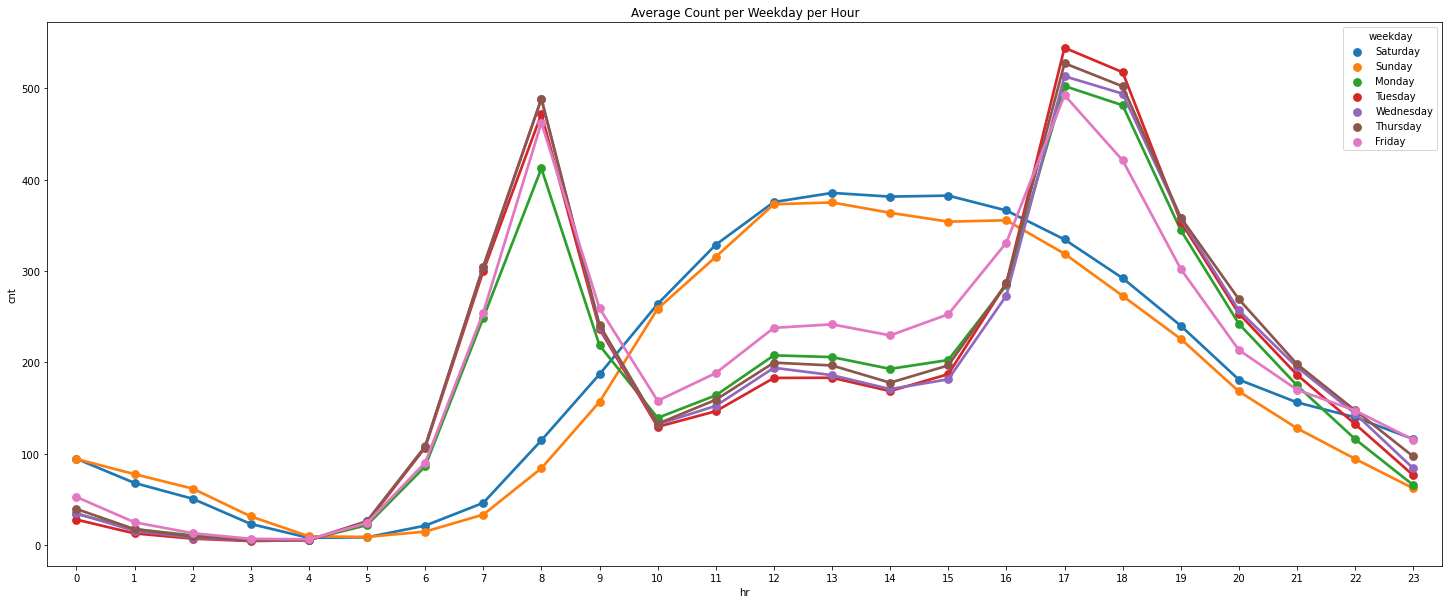

In [84]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='weekday', ci=0)
plt.title('Average Count per Weekday per Hour')
plt.show()

#### Insight
- Total dan rata-rata penyewaan sepeda untuk day Monday - Friday memiliki pola yang sama yaitu memiliki jumlah tertinggi pada jam 8 dan jam 17
- Total dan rata-rata penyewaan sepeda untuk day Sunday dan Saturday memiliki pola berbeda dengan day Monday - Friday, yaitu memiliki jumlah tertinggi pada jam 13.

In [85]:
pd.crosstab(index=df['workingday'], columns=df['hr'], values=df['cnt'], aggfunc='sum', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
workingday,,,,,,,,,,,,,,,,,,,,,,,,,
Non-Work,20884,15987,12123,5851,1876,1929,4292,10027,24406,39645,59115,72838,84606,86101,84233,82886,81480,74740,64643,53285,40190,32674,26694,19764,1000269
Work,18246,8177,4229,2323,2552,12332,50840,144144,236595,119793,67142,78482,99808,98818,91419,100263,146268,262120,245129,173504,124360,92771,68918,44177,2292410
All,39130,24164,16352,8174,4428,14261,55132,154171,261001,159438,126257,151320,184414,184919,175652,183149,227748,336860,309772,226789,164550,125445,95612,63941,3292679


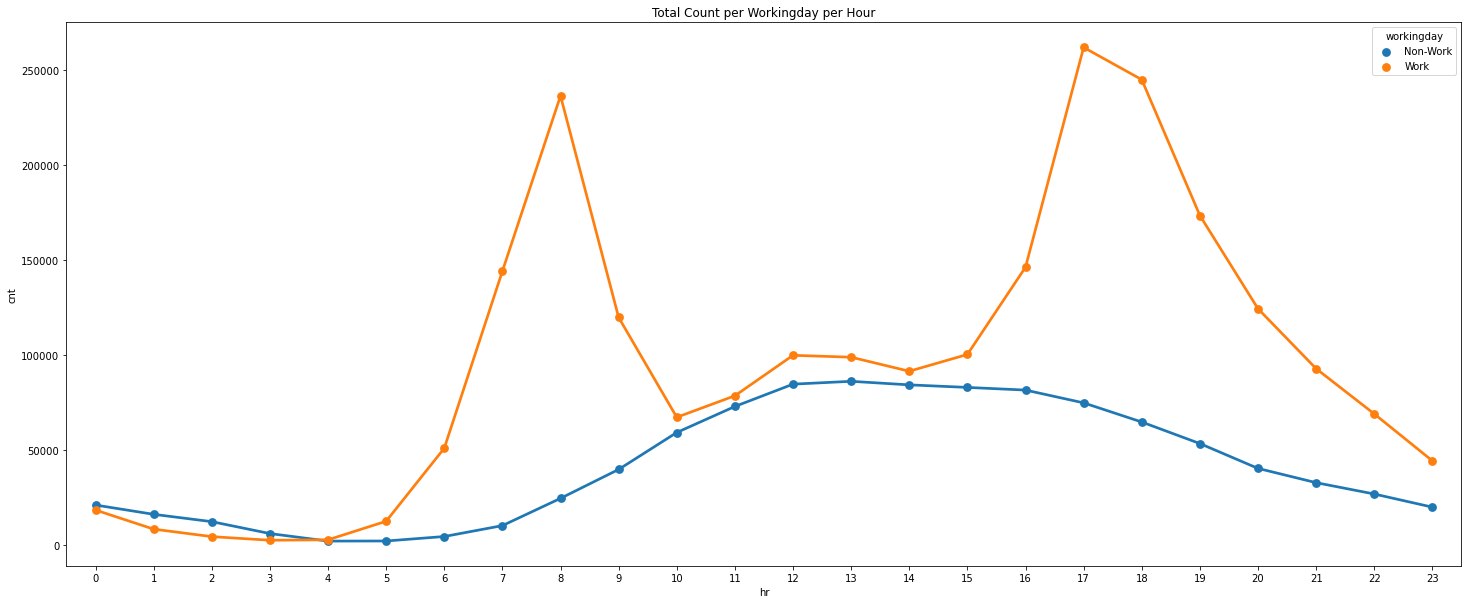

In [86]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='workingday', ci=0, estimator=sum)
plt.title('Total Count per Workingday per Hour')
plt.show()

In [87]:
pd.crosstab(index=df['workingday'], columns=df['hr'], values=df['cnt'], aggfunc='mean', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
workingday,,,,,,,,,,,,,,,,,,,,,,,,,
Non-Work,90.800000,69.508696,53.171053,25.775330,8.264317,8.689189,18.742358,43.406926,105.653680,171.623377,255.909091,315.316017,366.259740,372.731602,364.645022,358.813853,352.727273,323.549784,281.056522,231.673913,174.739130,142.060870,116.060870,85.930435,181.405332
Work,36.786290,16.552632,8.683778,4.942553,5.429787,24.913131,102.500000,290.612903,477.006048,241.518145,135.366935,158.229839,200.820926,198.429719,183.572289,201.331325,293.122244,525.290581,492.226908,348.401606,249.718876,186.287149,138.389558,88.708835,193.207754
All,53.898072,33.375691,22.869930,11.727403,6.352941,19.889819,76.044138,212.064649,359.011004,219.309491,173.668501,208.143054,253.315934,253.661180,240.949246,251.233196,311.983562,461.452055,425.510989,311.523352,226.030220,172.314560,131.335165,87.831044,189.463088


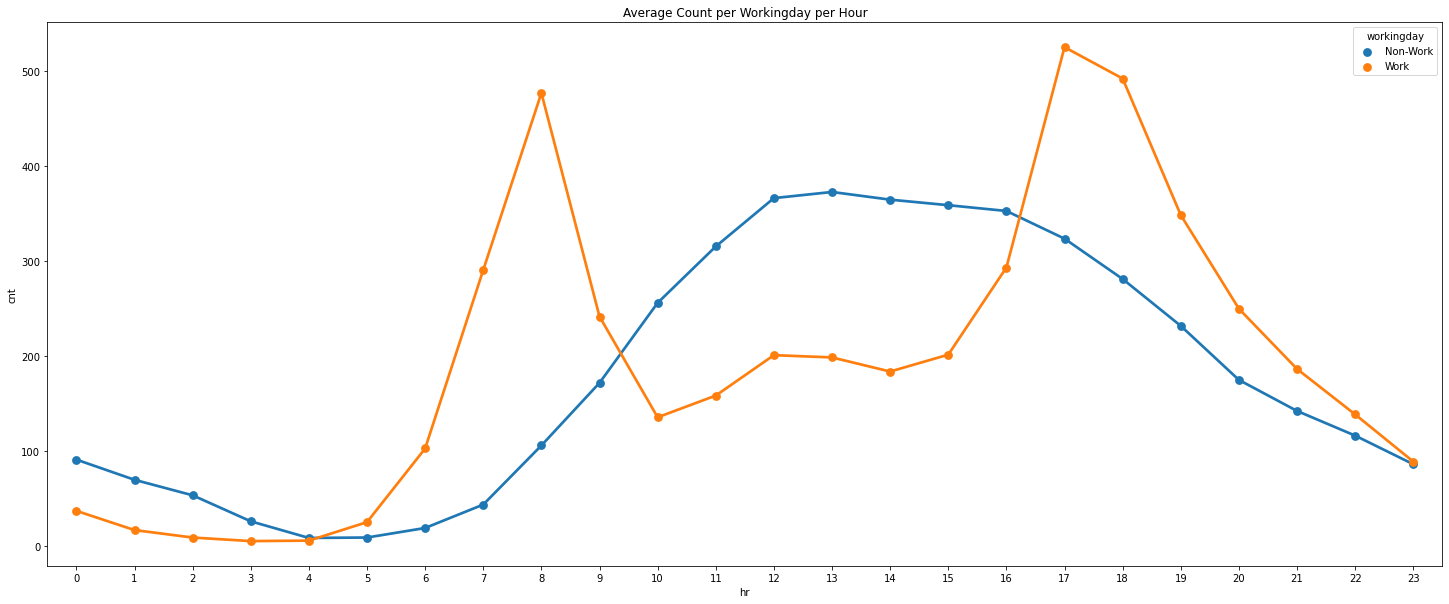

In [88]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='workingday', ci=0)
plt.title('Average Count per Workingday per Hour')
plt.show()

#### Insight
- Total dan rata-rata penyewaan sepeda untuk workingday Work memiliki pola yang sama dengan pola day Monday - Friday. 
- Total dan rata-rata penyewaan sepeda untuk workingday Non-Work memiliki pola yang sama dengan pola day Sunday dan Saturday.

In [89]:
pd.crosstab(index=df['weathersit'], columns=df['hr'], values=df['cnt'], aggfunc='sum', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
weathersit,,,,,,,,,,,,,,,,,,,,,,,,,
Clear,28930.0,16854.0,10907.0,5458.0,2931.0,9452.0,35862.0,96903.0,158998.0,97122.0,85457.0,104725.0,124915.0,131209.0,127726.0,133486.0,171230.0,253718.0,229220.0,171073.0,127332.0,95842.0,72584.0,46239.0,2338173
Cloudy,8738.0,6362.0,4614.0,2341.0,1230.0,4129.0,16191.0,48093.0,89604.0,55351.0,36678.0,42564.0,51950.0,46978.0,40479.0,40551.0,44946.0,62167.0,61686.0,45124.0,28636.0,23987.0,19159.0,14394.0,795952
Heavy Rain/Snow,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.0,NaN,164.0,NaN,NaN,NaN,NaN,NaN,223
Light Rain/Snow,1462.0,925.0,831.0,375.0,267.0,680.0,3079.0,9175.0,12399.0,6965.0,4122.0,4031.0,7549.0,6732.0,7447.0,9112.0,11536.0,20975.0,18702.0,10592.0,8582.0,5616.0,3869.0,3308.0,158331
All,39130.0,24164.0,16352.0,8174.0,4428.0,14261.0,55132.0,154171.0,261001.0,159438.0,126257.0,151320.0,184414.0,184919.0,175652.0,183149.0,227748.0,336860.0,309772.0,226789.0,164550.0,125445.0,95612.0,63941.0,3292679


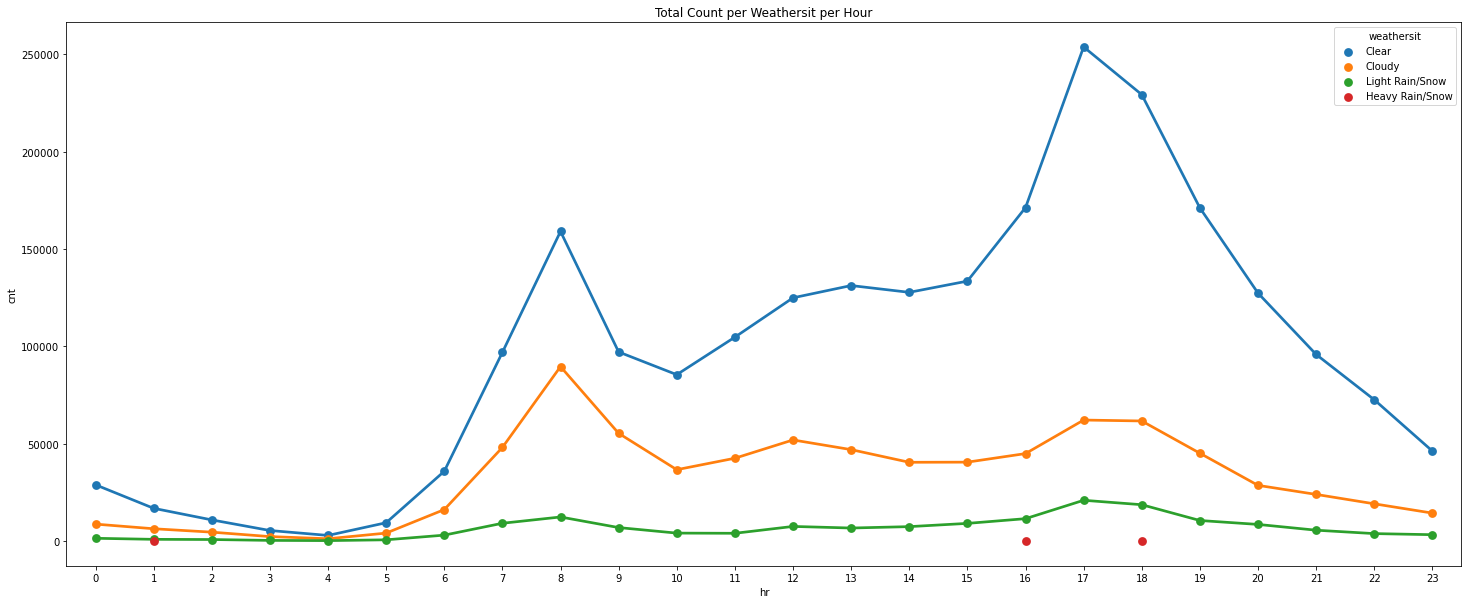

In [90]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='weathersit', ci=0, estimator=sum)
plt.title('Total Count per Weathersit per Hour')
plt.show()

#### Insight
- Untuk weathersit Clear total penyewaan sepeda bernilai paling tinggi untuk setiap jam. 
- Total penyewaan sepeda terendah untuk tiap jam terjadi pada weathersit Heavy Rain/Snow, hanya ada pada jam 1, 16 dan 18.
- Untuk weathersit Light Snow/Rain total penyewaan sepeda cukup rendah dan stabil untuk setiap jam.

In [91]:
pd.crosstab(index=df['weathersit'], columns=df['hr'], values=df['cnt'], aggfunc='mean', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
weathersit,,,,,,,,,,,,,,,,,,,,,,,,,
Clear,59.161554,34.395918,22.817992,11.995604,6.413567,20.414687,79.165563,218.742664,361.359091,226.391608,192.470721,234.284116,281.975169,283.388769,269.464135,275.228866,335.745098,500.429980,458.440000,336.096267,244.869231,186.826511,142.601179,93.981707,204.869272
Cloudy,47.232432,35.541899,25.491713,12.452128,6.721311,20.141463,74.612903,224.733645,391.283843,226.848361,159.469565,182.678112,225.869565,225.855769,208.654639,227.814607,299.640000,422.904762,390.417722,282.025000,204.542857,151.816456,116.823171,85.171598,175.165493
Heavy Rain/Snow,NaN,23.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.000000,NaN,164.000000,NaN,NaN,NaN,NaN,NaN,74.333333
Light Rain/Snow,28.115385,17.129630,14.839286,6.944444,4.684211,13.877551,55.981818,131.071429,213.775862,128.981481,77.773585,85.765957,137.254545,116.068966,122.081967,138.060606,167.188406,275.986842,271.043478,179.525424,126.205882,98.526316,70.345455,49.373134,111.579281
All,53.898072,33.375691,22.869930,11.727403,6.352941,19.889819,76.044138,212.064649,359.011004,219.309491,173.668501,208.143054,253.315934,253.661180,240.949246,251.233196,311.983562,461.452055,425.510989,311.523352,226.030220,172.314560,131.335165,87.831044,189.463088


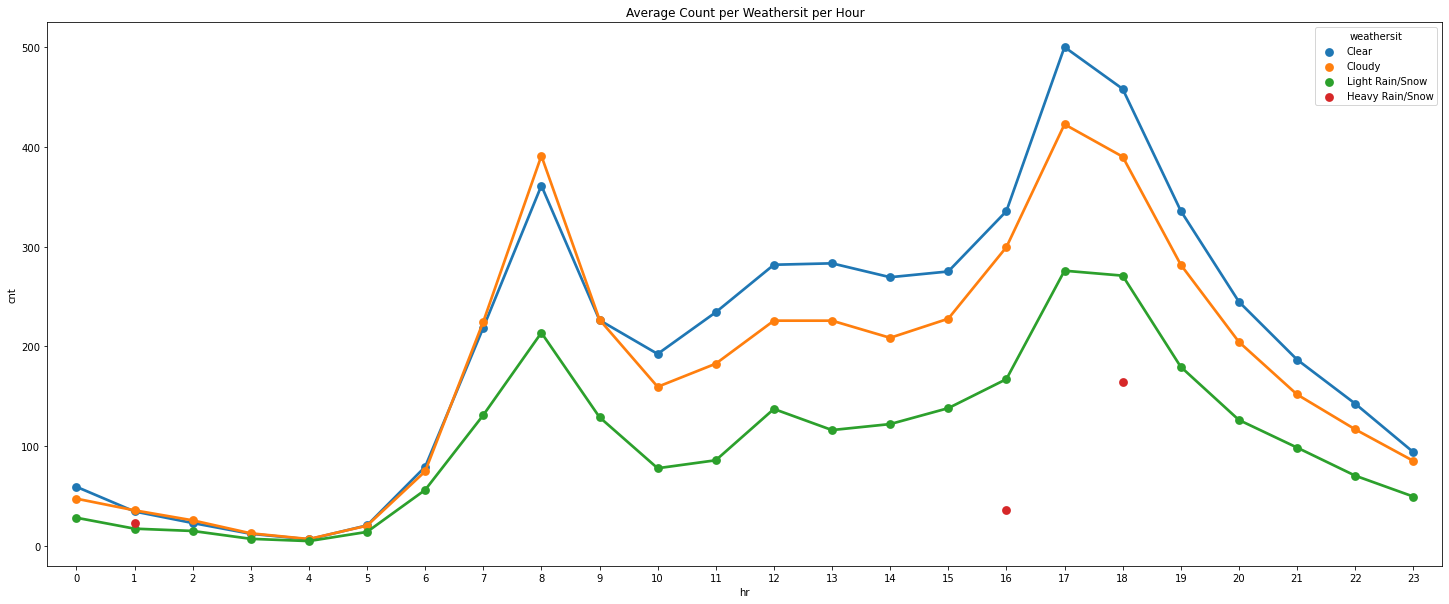

In [92]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='weathersit', ci=0)
plt.title('Average Count per Weathersit per Hour')
plt.show()

#### Insight
- Rata-rata penyewaan sepeda untuk setiap weathersit memiliki pola yang sama (kecuali weathersit Heavy Rain/Snow).
- Secara kesuluruhan rata-rata tertinggi untuk setiap jam ada pada weathersit Clear, tetapi rata-rata untuk weathersit Cloudy pada jam 8 sedikit lebih tinggi dari weathersit Clear. 

In [93]:
pd.crosstab(index=df['temp_cat'], columns=df['hr'], values=df['cnt'], aggfunc='sum', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
temp_cat,,,,,,,,,,,,,,,,,,,,,,,,,
Cold,9257,6330,4480,2270,1261,4295,16485,46726,82744,45891,28964,29916,32217,27489,23633,23787,29179,45831,45481,36254,27531,23290,19245,13528,626084
Cool,12816,8315,5622,2751,1533,5067,19433,50335,82540,47366,38082,44201,52429,51582,47668,51217,60519,89954,83093,63391,45619,35781,28979,20743,949036
Warm,16749,9325,6119,3153,1634,4899,19214,57110,94900,62181,52938,65473,82085,85233,80975,84160,110289,162510,152574,113197,84184,62281,45572,29474,1486229
Hot,308,194,131,0,0,0,0,0,817,4000,6273,11730,17683,20615,23376,23985,27761,38565,28624,13947,7216,4093,1816,196,231330
All,39130,24164,16352,8174,4428,14261,55132,154171,261001,159438,126257,151320,184414,184919,175652,183149,227748,336860,309772,226789,164550,125445,95612,63941,3292679


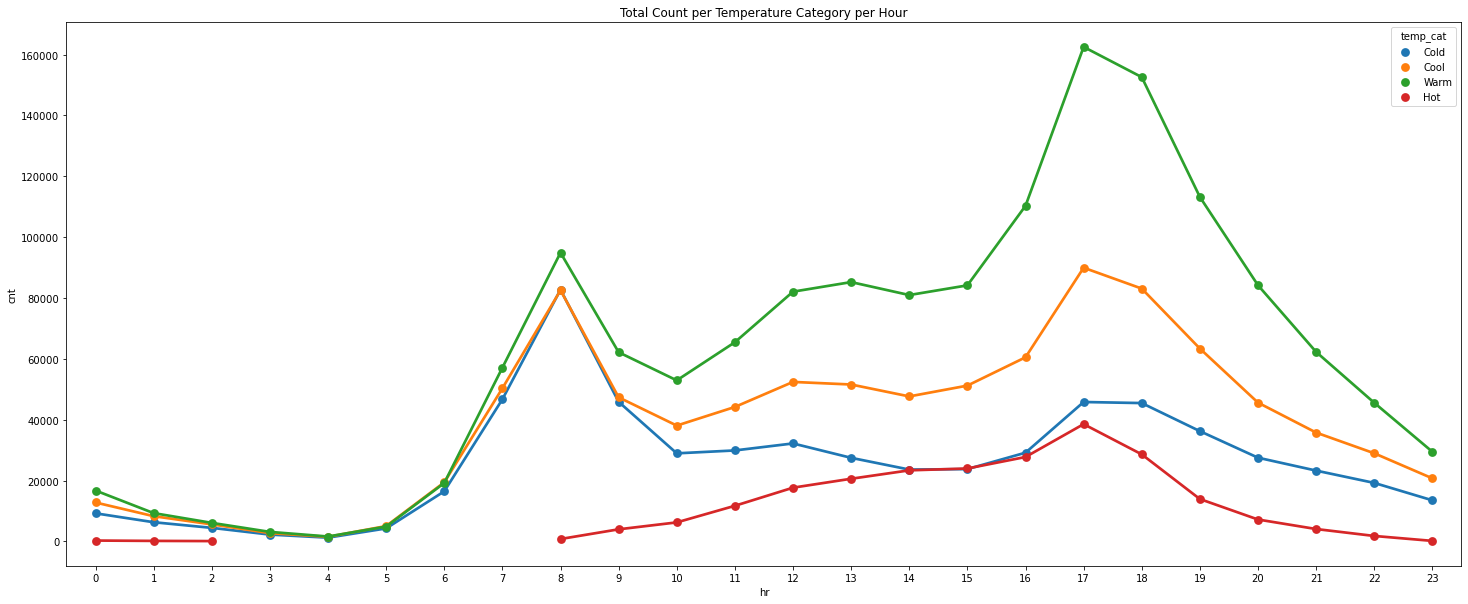

In [94]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='temp_cat', ci=0, estimator=sum)
plt.title('Total Count per Temperature Category per Hour')
plt.show()

#### Insight
- Total penyewaan sepeda paling tinggi ada pada temperatur Warm.
- Sebaliknya pada temperatur Hot, total penyewaan bernilai paling sedikit.

In [95]:
pd.crosstab(index=df['temp_cat'], columns=df['hr'], values=df['cnt'], aggfunc='mean', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
temp_cat,,,,,,,,,,,,,,,,,,,,,,,,,
Cold,34.412639,23.018182,16.173285,8.470149,4.552347,14.081967,53.006431,150.244373,279.540541,169.339483,117.739837,134.756757,159.490099,150.213115,138.204678,143.295181,169.645349,247.735135,228.547739,167.842593,120.750000,95.061224,74.883268,51.831418,107.704111
Cool,57.470852,37.120536,24.766520,12.226667,6.905405,23.243119,88.735160,245.536585,406.600985,240.436548,183.971014,214.567961,253.280193,249.188406,235.980198,253.549505,301.089552,438.800000,407.318627,303.306220,221.451456,175.397059,137.995238,93.017937,187.704905
Warm,72.506494,41.816143,29.277512,15.455882,8.252525,25.252577,98.533333,270.663507,425.560538,256.946281,218.752066,264.004032,323.169291,321.633962,301.022305,306.036364,395.301075,601.888889,567.189591,420.806691,309.500000,235.912879,180.126482,121.793388,256.202207
Hot,102.666667,97.000000,65.500000,NaN,NaN,NaN,NaN,NaN,163.400000,235.294118,196.031250,230.000000,272.046154,278.581081,268.689655,278.895349,355.910256,550.928571,511.142857,410.205882,328.000000,272.866667,227.000000,98.000000,326.276446
All,53.898072,33.375691,22.869930,11.727403,6.352941,19.889819,76.044138,212.064649,359.011004,219.309491,173.668501,208.143054,253.315934,253.661180,240.949246,251.233196,311.983562,461.452055,425.510989,311.523352,226.030220,172.314560,131.335165,87.831044,189.463088


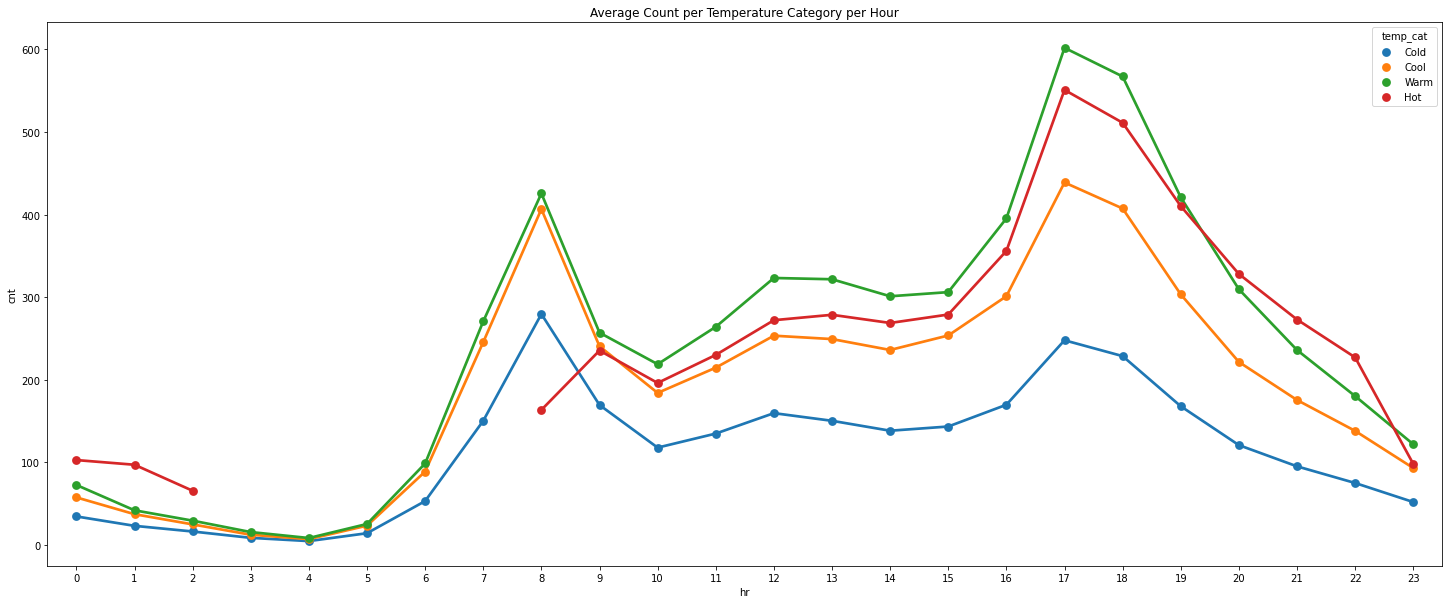

In [96]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='temp_cat', ci=0)
plt.title('Average Count per Temperature Category per Hour')
plt.show()

#### Insight
- Dapat dilihat bahwa pengguna cenderung bersepeda pada hari yang Panas/Hangat dibanding suhu dingin.

In [97]:
pd.crosstab(index=df['atemp_cat'], columns=df['hr'], values=df['cnt'], aggfunc='sum', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
atemp_cat,,,,,,,,,,,,,,,,,,,,,,,,,
Cold,9345,6384,4499,2276,1270,4331,16642,47105,83412,46269,29195,30219,32582,27846,23961,24170,29667,46622,46150,36745,27890,23545,19458,13649,633232
Cool,13763,8962,6141,2991,1704,5399,21405,53817,85387,48905,38767,44304,52562,51781,48366,51752,61042,90632,84472,65128,47326,37215,30852,22163,974836
Warm,14477,8109,5294,2682,1371,4408,16458,51879,81564,53779,44579,56334,69377,70407,70717,72466,93978,136506,125878,94931,71347,53742,38678,24918,1263879
Hot,1545,709,418,225,83,123,627,1370,10638,10277,12879,19331,27881,33479,30467,33217,41145,60791,51180,28724,17442,10718,6475,3211,402955
Extreme,0,0,0,0,0,0,0,0,0,208,837,1132,2012,1406,2141,1544,1916,2309,2092,1261,545,225,149,0,17777
All,39130,24164,16352,8174,4428,14261,55132,154171,261001,159438,126257,151320,184414,184919,175652,183149,227748,336860,309772,226789,164550,125445,95612,63941,3292679


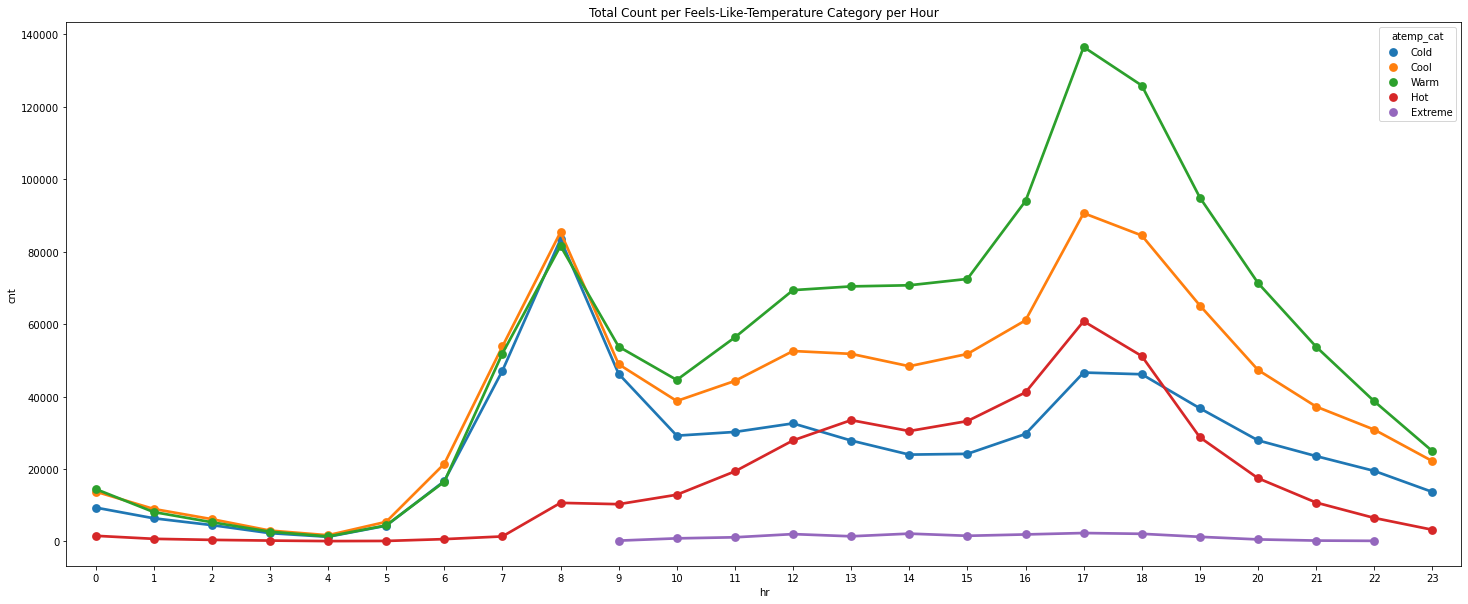

In [98]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='atemp_cat', ci=0, estimator=sum)
plt.title('Total Count per Feels-Like-Temperature Category per Hour')
plt.show()

In [99]:
pd.crosstab(index=df['atemp_cat'], columns=df['hr'], values=df['cnt'], aggfunc='mean', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
atemp_cat,,,,,,,,,,,,,,,,,,,,,,,,,
Cold,34.611111,23.130435,16.183453,8.460967,4.568345,14.153595,53.339744,150.977564,280.848485,170.106618,118.198381,135.511211,160.502463,151.336957,139.308140,144.730539,171.485549,250.655914,230.750000,169.331797,121.790393,95.711382,75.418605,52.095420,108.485866
Cool,57.345833,37.033058,25.168033,12.258197,6.983607,22.974468,89.936975,243.515837,400.877934,236.256039,182.004695,211.980861,251.492823,246.576190,233.652174,251.223301,299.225490,435.730769,406.115385,301.518519,220.120930,174.718310,136.513274,92.732218,183.550367
Warm,73.487310,42.678947,29.411111,15.593023,8.259036,26.238095,99.144578,281.951087,431.555556,262.336585,222.895000,269.540670,327.250000,327.474419,306.134199,309.683761,398.211864,609.401786,564.475336,421.915556,312.925439,237.796460,182.443396,123.356436,258.250715
Hot,81.315789,44.312500,32.153846,18.750000,9.222222,15.375000,69.666667,137.000000,379.928571,244.690476,204.428571,238.654321,293.484211,293.675439,282.101852,291.377193,374.045455,568.140187,556.304348,428.716418,323.000000,255.190476,208.870968,128.440000,317.537431
Extreme,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208.000000,209.250000,226.400000,223.555556,234.333333,194.636364,193.000000,273.714286,461.800000,418.400000,420.333333,272.500000,225.000000,149.000000,NaN,261.426471
All,53.898072,33.375691,22.869930,11.727403,6.352941,19.889819,76.044138,212.064649,359.011004,219.309491,173.668501,208.143054,253.315934,253.661180,240.949246,251.233196,311.983562,461.452055,425.510989,311.523352,226.030220,172.314560,131.335165,87.831044,189.463088


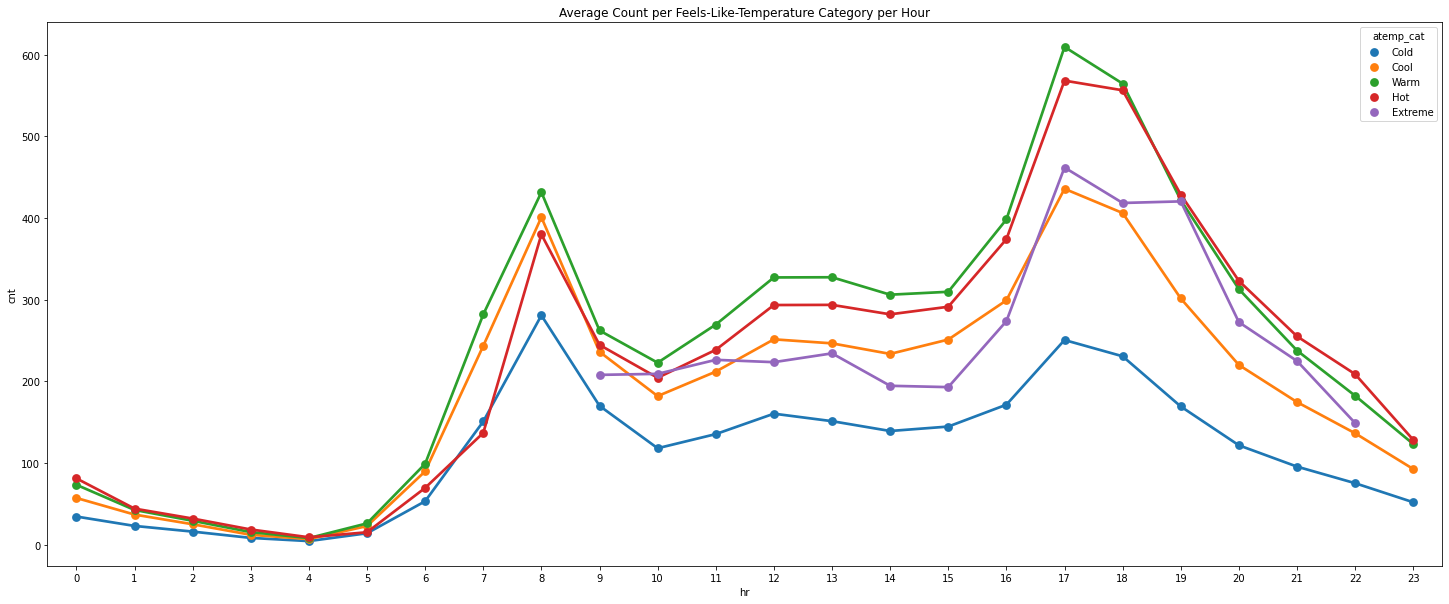

In [100]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='atemp_cat', ci=0)
plt.title('Average Count per Feels-Like-Temperature Category per Hour')
plt.show()

#### Insight
- Sama dengan temp, untuk variabel atemp, total dan rata-rata tertinggi didominasi oleh kategori atemp Warm. 
- Total penyewaan untuk kategori atemp hot mulai mengalami kenaikan pada jam 9.

In [101]:
pd.crosstab(index=df['hum_cat'], columns=df['hr'], values=df['cnt'], aggfunc='sum', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
hum_cat,,,,,,,,,,,,,,,,,,,,,,,,,
Too Dry,377,258,153,67,13,38,137,446,790,1041,1952,4562,10338,15393,20891,25657,33428,42676,35121,17725,7027,3364,1276,661,223391
Optimum,11867,6464,3978,1548,681,2009,8771,29906,70907,62470,61369,90355,125732,132269,121048,120985,146379,213321,180985,122168,79888,52610,36821,22209,1704740
Too Moist,26886,17442,12221,6559,3734,12214,46224,123819,189304,95927,62936,56403,48344,37257,33713,36507,47941,80863,93666,86896,77635,69471,57515,41071,1364548
All,39130,24164,16352,8174,4428,14261,55132,154171,261001,159438,126257,151320,184414,184919,175652,183149,227748,336860,309772,226789,164550,125445,95612,63941,3292679


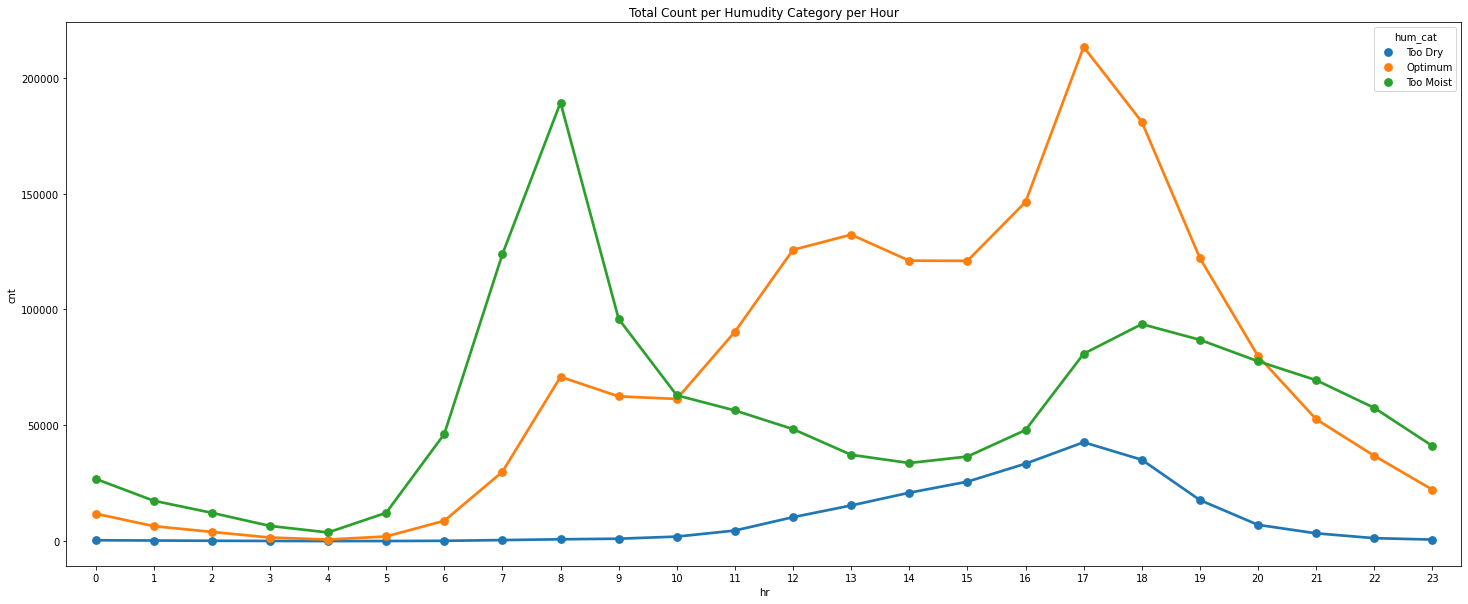

In [102]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='hum_cat', ci=0, estimator=sum)
plt.title('Total Count per Humudity Category per Hour')
plt.show()

#### Insight
- Untuk jam 0-10 total penyewaan sepeda didominasi oleh kategori humidity too moist. 
- Sedangkan untuk jam 10-20 total penyewaan sepeda didominasi oleh kategori humidity optimum. 

In [103]:
pd.crosstab(index=df['hum_cat'], columns=df['hr'], values=df['cnt'], aggfunc='mean', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
hum_cat,,,,,,,,,,,,,,,,,,,,,,,,,
Too Dry,37.700000,32.250000,19.125000,9.571429,4.333333,12.666667,34.250000,89.200000,197.500000,148.714286,162.666667,190.083333,258.450000,252.344262,248.702381,256.570000,312.411215,474.177778,456.116883,340.865385,250.964286,177.052632,106.333333,73.444444,288.618863
Optimum,55.195349,32.812183,23.678571,10.901408,5.238462,15.219697,62.650000,188.088050,349.295567,222.313167,179.967742,219.841849,268.085288,272.158436,257.548936,270.055804,338.057737,498.413551,446.876543,326.652406,231.559420,174.784053,132.449640,88.836000,236.572301
Too Moist,53.664671,33.606936,22.673469,11.968978,6.620567,20.986254,79.559380,219.927176,364.046154,218.512528,168.278075,193.160959,220.748858,204.708791,192.645714,201.696133,252.321053,381.429245,380.756098,287.735099,218.690141,170.272059,131.312785,87.571429,145.180126
All,53.898072,33.375691,22.869930,11.727403,6.352941,19.889819,76.044138,212.064649,359.011004,219.309491,173.668501,208.143054,253.315934,253.661180,240.949246,251.233196,311.983562,461.452055,425.510989,311.523352,226.030220,172.314560,131.335165,87.831044,189.463088


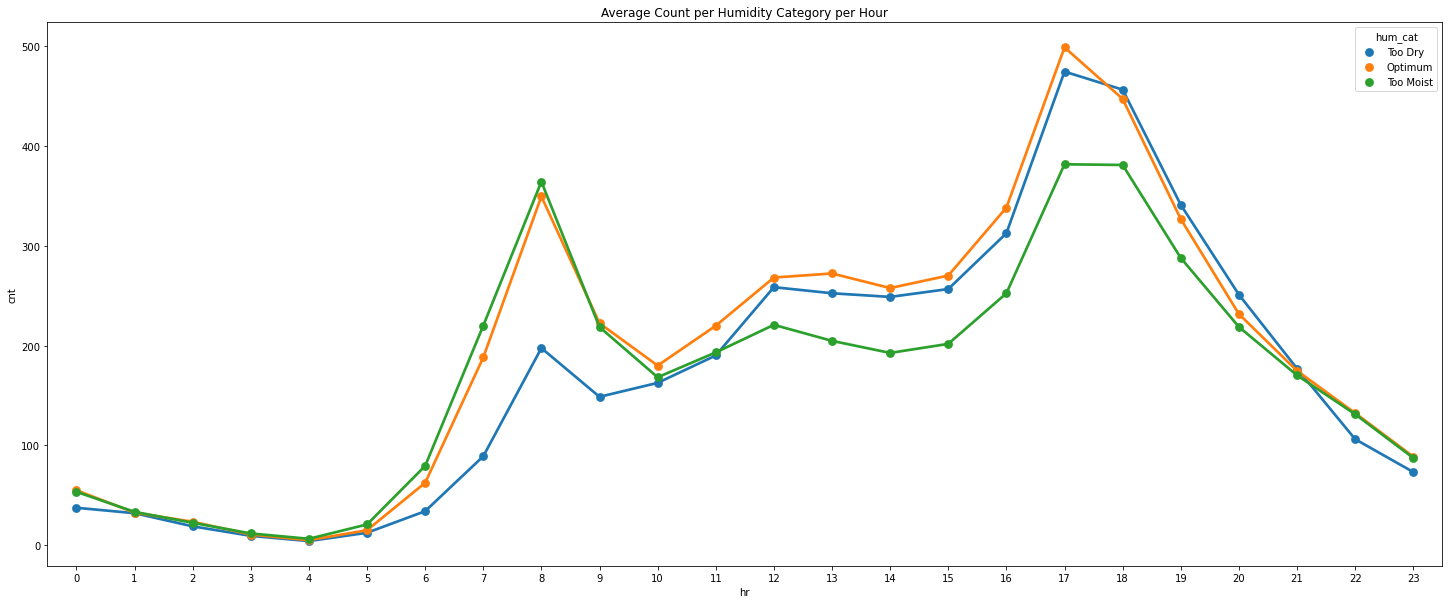

In [104]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='hum_cat', ci=0)
plt.title('Average Count per Humidity Category per Hour')
plt.show()

#### Insight
- Untuk jam 0-11 rata-rata penyewaan sepeda didominasi oleh kategori humidity optimum dan too moist. 
- Sedangkan untuk jam 10-21 rata-rata penyewaan sepeda didominasi oleh kategori humidity optimum dan too dry. 

In [105]:
pd.crosstab(index=df['wind_cat'], columns=df['hr'], values=df['cnt'], aggfunc='sum', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
wind_cat,,,,,,,,,,,,,,,,,,,,,,,,,
Slow Wind,36895,22683,15570,7800,4140,13460,52307,143387,235105,138000,109412,128860,149678,153196,139071,146027,178722,263353,256862,195421,148167,115113,88483,60158,2801870
Normal,2235,1471,747,360,287,801,2825,10784,25867,21383,16543,21985,33713,30598,36097,36398,48259,71417,51613,31011,16175,9854,6850,3697,480970
Strong Wind,0,10,35,14,1,0,0,0,29,55,302,475,1023,1125,484,724,767,2090,1297,357,208,478,279,86,9839
All,39130,24164,16352,8174,4428,14261,55132,154171,261001,159438,126257,151320,184414,184919,175652,183149,227748,336860,309772,226789,164550,125445,95612,63941,3292679


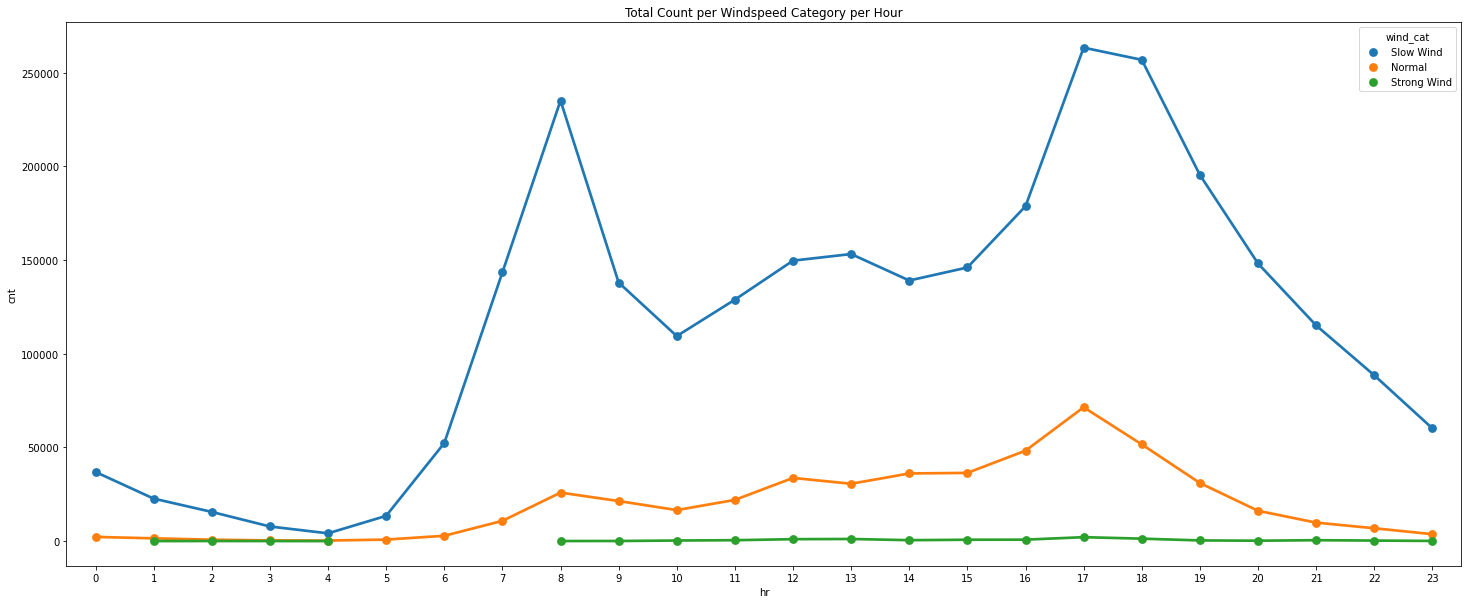

In [106]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='wind_cat', ci=0, estimator=sum)
plt.title('Total Count per Windspeed Category per Hour')
plt.show()

#### Insight
- Total penyewaaan sepeda didominasi oleh kategori slow wind.

In [107]:
pd.crosstab(index=df['wind_cat'], columns=df['hr'], values=df['cnt'], aggfunc='mean', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
wind_cat,,,,,,,,,,,,,,,,,,,,,,,,,
Slow Wind,55.564759,34.420334,23.378378,11.944870,6.468750,20.089552,77.722140,214.651198,362.257319,222.940226,178.195440,215.125209,262.133100,262.771870,247.017762,257.998233,318.010676,467.767318,436.840136,322.476898,232.966981,177.918083,135.918587,90.327327,187.090678
Normal,36.048387,23.349206,15.893617,8.372093,5.125000,17.042553,54.326923,182.779661,335.935065,199.841121,149.036036,175.880000,221.796053,218.557143,221.453988,230.367089,292.478788,449.163522,385.171642,260.596639,183.806818,127.974026,91.333333,60.606557,205.542735
Strong Wind,NaN,5.000000,17.500000,14.000000,1.000000,NaN,NaN,NaN,29.000000,55.000000,151.000000,158.333333,204.600000,187.500000,161.333333,144.800000,255.666667,261.250000,216.166667,119.000000,52.000000,119.500000,139.500000,86.000000,156.174603
All,53.898072,33.375691,22.869930,11.727403,6.352941,19.889819,76.044138,212.064649,359.011004,219.309491,173.668501,208.143054,253.315934,253.661180,240.949246,251.233196,311.983562,461.452055,425.510989,311.523352,226.030220,172.314560,131.335165,87.831044,189.463088


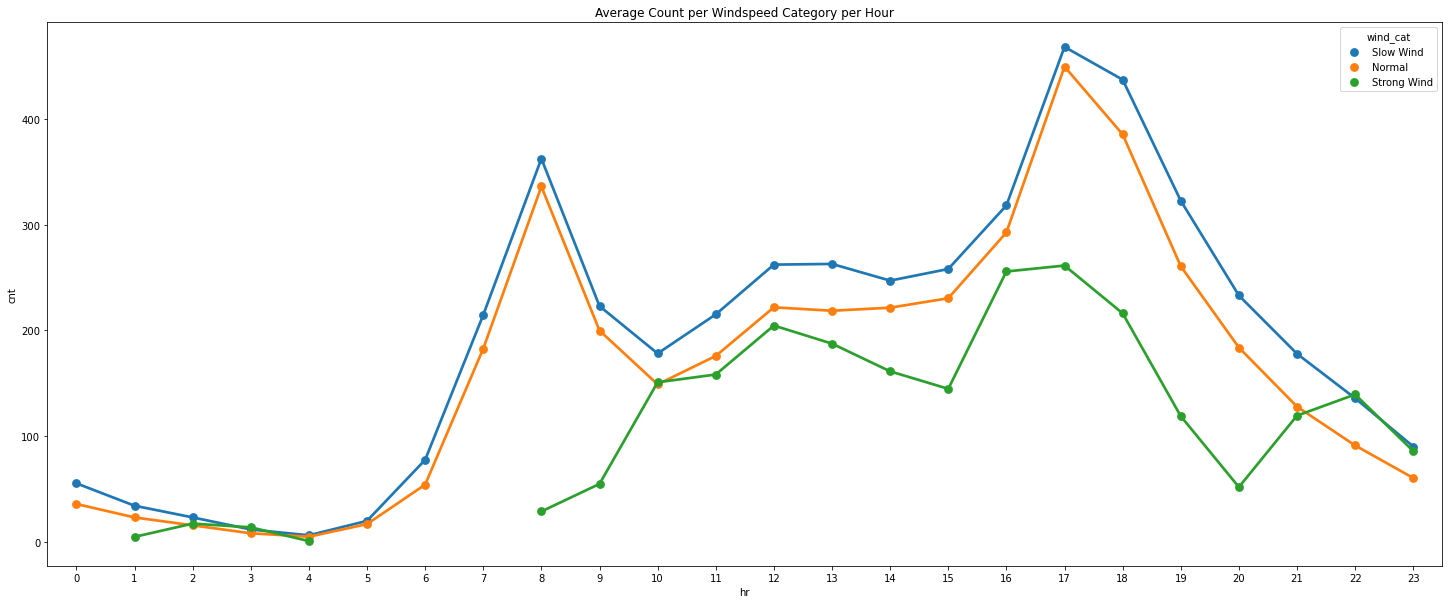

In [108]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='wind_cat', ci=0)
plt.title('Average Count per Windspeed Category per Hour')
plt.show()

#### Insight
- Rata-rata penyewaaan sepeda didominasi oleh kategori slow wind dan normal wind.
- Pada kategori strong wind, tidak ada penyewaan sepeda pada jam 0-1 dan 4-8.


In [109]:
pd.crosstab(index=df['event'], columns=df['hr'], values=df['cnt'], aggfunc='sum', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
event,,,,,,,,,,,,,,,,,,,,,,,,,
No,39130.0,24164.0,16352.0,8174.0,4428.0,14261.0,55132.0,154171.0,170715.0,159438.0,126257.0,150010.0,172651.0,169129.0,165396.0,174172.0,219529.0,214962.0,209297.0,217395.0,164550.0,125445.0,95612.0,63941.0,2914311
Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90286.0,NaN,NaN,1310.0,11763.0,15790.0,10256.0,8977.0,8219.0,121898.0,100475.0,9394.0,NaN,NaN,NaN,NaN,378368
All,39130.0,24164.0,16352.0,8174.0,4428.0,14261.0,55132.0,154171.0,261001.0,159438.0,126257.0,151320.0,184414.0,184919.0,175652.0,183149.0,227748.0,336860.0,309772.0,226789.0,164550.0,125445.0,95612.0,63941.0,3292679


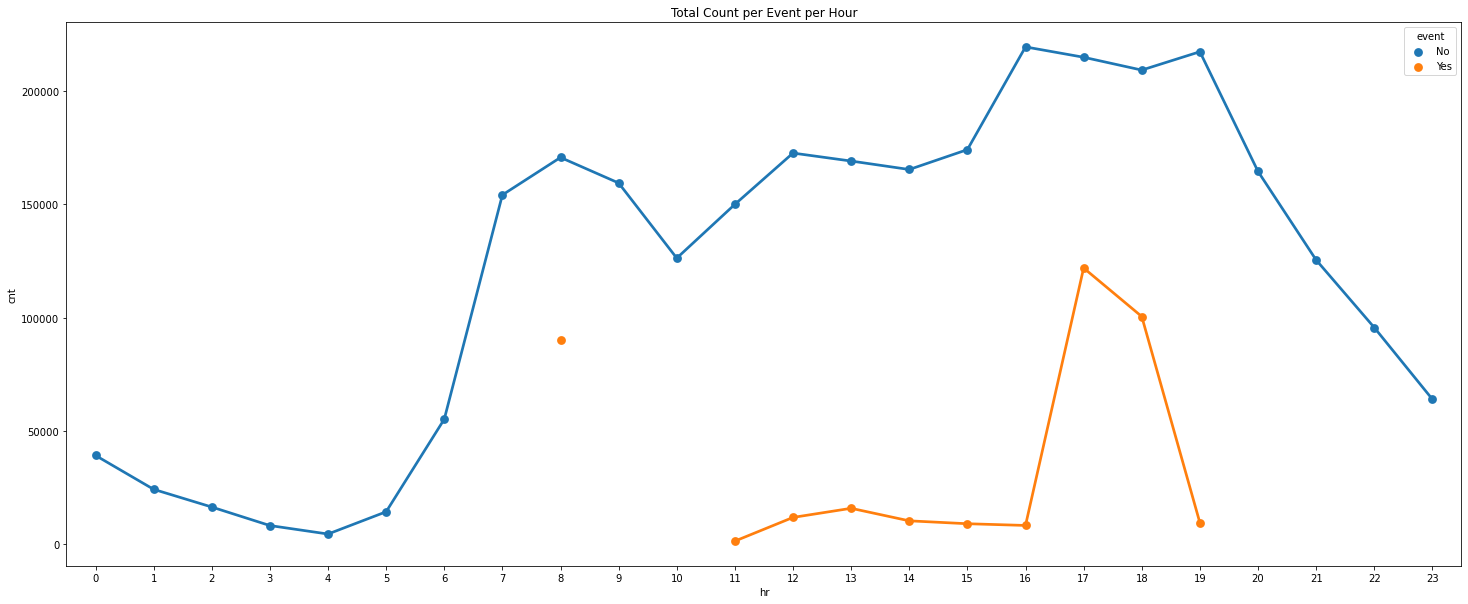

In [110]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='event', ci=0, estimator=sum)
plt.title('Total Count per Event per Hour')
plt.show()

In [111]:
pd.crosstab(index=df['event'], columns=df['hr'], values=df['cnt'], aggfunc='mean', margins=True)

hr,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,All
event,,,,,,,,,,,,,,,,,,,,,,,,,
No,53.898072,33.375691,22.86993,11.727403,6.352941,19.889819,76.044138,212.064649,284.525000,219.309491,173.668501,206.910345,242.828411,239.559490,231.647059,243.256983,305.750696,372.551127,349.410684,304.474790,226.03022,172.31456,131.335165,87.831044,172.710146
Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,710.913386,NaN,NaN,655.000000,691.941176,686.521739,683.733333,690.538462,684.916667,796.718954,778.875969,671.000000,NaN,NaN,NaN,NaN,749.243564
All,53.898072,33.375691,22.86993,11.727403,6.352941,19.889819,76.044138,212.064649,359.011004,219.309491,173.668501,208.143054,253.315934,253.661180,240.949246,251.233196,311.983562,461.452055,425.510989,311.523352,226.03022,172.31456,131.335165,87.831044,189.463088


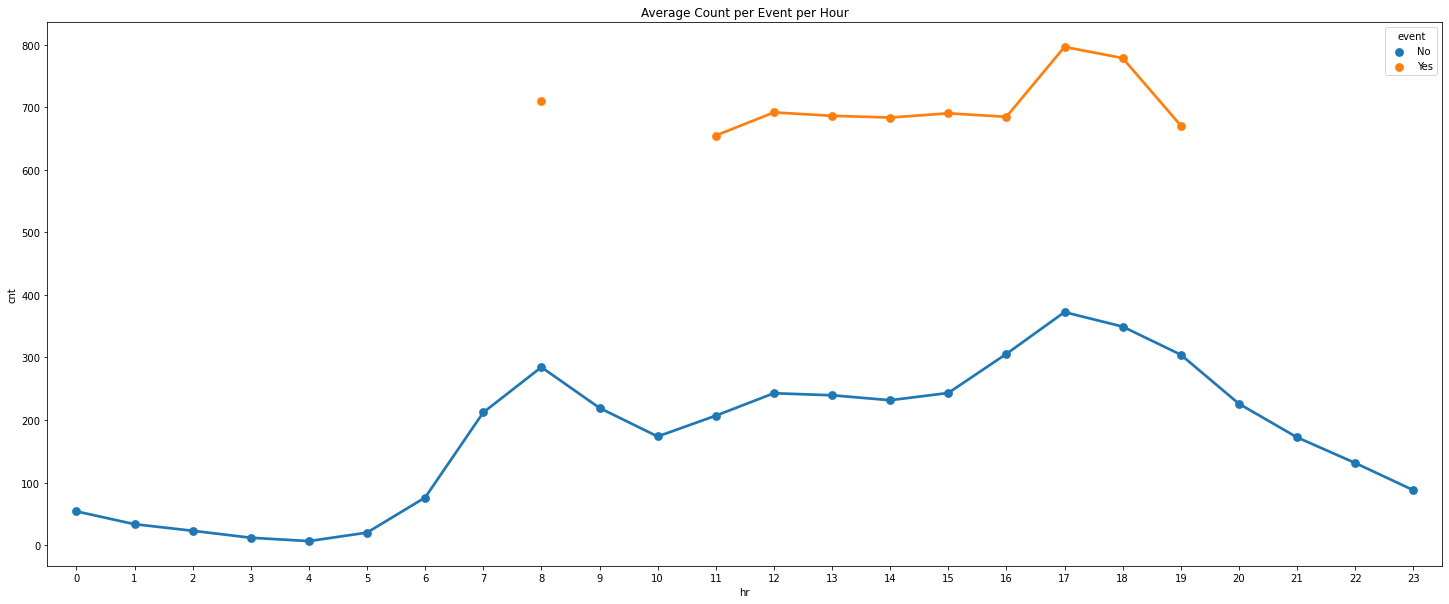

In [112]:
plt.figure(figsize=(25,10))
sns.pointplot(x='hr',y='cnt', data=df, hue='event', ci=0)
plt.title('Average Count per Event per Hour')
plt.show()

#### Insight
- Total penyewaan sepeda pada hari Non-Event jauh lebih tinggi dari hari dengan event.  
- Rata-rata penyewaan sepeda untuk hari dengan event lebih tinggi (pada jam-jam tertentu dimana event terjadi) daripada hari biasa.

## Resume Insight

- Season dengan Jumlah penyewaan sepeda Terbanyak ada di Season Summer dengan jumlah 1.061.129 sepeda. Season dengan Rata-rata penyewaan sepeda Terbanyak ada di Season Summer dengan rata-rata 236,02 sepeda per jam. Season mempengaruhi jumlah Count dengan urutan dari terbanyak ke terkecil adalah Summer - Spring - Fall - Winter

- Terjadi peningkatan Jumlah Penyewaan Sepeda sebesar 64,87% di tahun 2012. Jumlah Penyewaan Sepeda 1.243.103 di tahun 2011 menjadi 2.049.576 di tahun 2012. Terjadi peningkatan Rata-rata Penyewaan Sepeda per jam sebesar 63,19% di tahun 2012. Rata-rata Penyewaan Sepeda per jam 143,79 di tahun 2011 menjadi 234,66 di tahun 2012

- Month dengan Jumlah penyewaan sepeda Terbanyak ada di Month August dengan jumlah 351.194 sepeda. Month dengan Rata-rata penyewaan sepeda Terbanyak ada di Month September dengan rata-rata 240,77 sepeda per jam. Month mempengaruhi jumlah Count melihat perbedaan jumlah dan rata rata penyewaan sepeda setiap bulannya

- Hour dengan Jumlah penyewaan sepeda Tinggi pada Jam Berangkat Kerja (Hour 8) dengan jumlah 261.001 sepeda dan Jam Pulang Kerja (Hour 17) dengan jumlah 336.860 sepeda. Hour dengan Rata-rata penyewaan sepeda Tinggi pada Jam Berangkat Kerja (Hour 8) dengan jumlah 359,01 sepeda dan Jam Pulang Kerja (Hour 17) dengan jumlah 461,45 sepeda. Hour mempengaruhi jumlah Count melihat perbedaan jumlah dan rata rata penyewaan sepeda setiap Jam nya

- Holiday memiliki Jumlah penyewaan sepeda 3.214.244, lebih banyak dibandingkan Non-Holiday yang hanya 78.435. Holiday memiliki Rata-rata penyewaan 190,43 sepeda per jam, lebih tinggi dibandingkan Holiday 1 dengan rata-rata penyewaan 156,87 sepeda per jam. Holiday mempengaruhi jumlah Count dilihat dari perbedaan yang cukup siginifikan di Jumlah penyewaan sepeda

- Weekday dengan Jumlah penyewaan sepeda Tinggi pada Weekday Friday dengan jumlah 487.790 sepeda. Weekday dengan Rata-rata penyewaan sepeda Tinggi pada Weekday Thuraday dengan jumlah 196,44 sepeda per jam. Weekday mempengaruhi jumlah Count melihat perbedaan jumlah dan rata rata penyewaan sepeda setiap Jam nya walau tidak siginifikan

- Work memiliki Jumlah penyewaan sepeda 2.292.410, lebih banyak dibandingkan Non-Work yang hanya 1.000.269. Work memiliki Rata-rata penyewaan 193,21 sepeda per jam, lebih tinggi dibandingkan Non-Work dengan rata-rata penyewaan 181,41 sepeda per jam. Workingday mempengaruhi jumlah Count dilihat dari perbedaan yang cukup siginifikan di Jumlah penyewaan sepeda

- Weathersit dengan Jumlah penyewaan sepeda Tinggi pada Weathersit Clear dengan jumlah 2.338.173 sepeda. Weathersit dengan Rata-rata penyewaan sepeda Tinggi pada Weathersit Clear dengan jumlah 204,87 sepeda per jam. Weathersit mempengaruhi jumlah Count melihat perbedaan jumlah dan rata rata penyewaan sepeda setiap Weathersit

- Temp dengan Jumlah penyewaan sepeda Tinggi pada Temp Warm (21-30 derajat celcius) dengan jumlah 1.486.229 sepeda. Temp dengan Rata-rata penyewaan sepeda Tinggi pada Temp Hot (>30 derajat celcius) dengan jumlah 326.28 sepeda per jam. Temp mempengaruhi jumlah Count melihat perbedaan jumlah dan rata rata penyewaan sepeda setiap Temp Category

- atemp dengan Jumlah penyewaan sepeda Tinggi pada atemp Warm (21-30 derajat celcius) dengan jumlah 1.263.879 sepeda. atemp dengan Rata-rata penyewaan sepeda Tinggi pada atemp Hot (31-40 derajat celcius) dengan jumlah 317.54 sepeda per jam atemp mempengaruhi jumlah Count melihat perbedaan jumlah dan rata rata penyewaan sepeda setiap atemp category

- Humidity dengan Jumlah penyewaan sepeda Tinggi pada Humidity Optimum (31-60 %) dengan jumlah 1.704.740 sepeda. Humidity dengan Rata-rata penyewaan sepeda Tinggi pada Humidity Too Dry (0-30 %) dengan jumlah 288,61 sepeda per jam. Humidity mempengaruhi jumlah Count melihat perbedaan jumlah dan rata rata penyewaan sepeda setiap Humidity Category

- Windspeed dengan Jumlah penyewaan sepeda Tinggi pada Windspeed Slow Wind (0-20 km/h) dengan jumlah 2.801.870 sepeda. Windspeed dengan Rata-rata penyewaan sepeda Tinggi pada Windspeed Normal (21-40 km/h) dengan jumlah 205,54 sepeda per jam. Windspeed mempengaruhi jumlah Count melihat perbedaan jumlah dan rata rata penyewaan sepeda setiap Windspeed Category

- Event (No) memiliki Jumlah penyewaan sepeda 2.914.311, lebih banyak dibandingkan Event (Yes) yang hanya 378.368. Event (Yes) memiliki Rata-rata penyewaan 749,24 sepeda per jam, lebih tinggi dibandingkan Event (No) dengan rata-rata penyewaan 172,71 sepeda per jam. Event mempengaruhi jumlah Count dilihat dari perbedaan yang cukup siginifikan di Jumlah dan rata-rata penyewaan sepeda

- Total dan rata-rata penyewaan sepeda pada season Winter memiliki jumlah paling kecil untuk setiap jam. Total dan rata-rata penyewaan sepeda pada season Summer memiliki jumlah paling besar untuk setiap jam. Untuk season Spring dan Fall perbedaan total dan rata-rata penyewaan sepeda tidak berbeda jauh.

- Total penyewaan sepeda per jam untuk Holiday cenderung kecil dan konstan. Rata-rata penyewaan sepeda tertinggi per jam untuk Holiday ada di jam 13.

- Total dan rata-rata penyewaan sepeda untuk day Monday - Friday memiliki pola yang sama yaitu memiliki jumlah tertinggi pada jam 8 dan jam 17. Total dan rata-rata penyewaan sepeda untuk day Sunday dan Saturday memiliki pola berbeda dengan day Monday - Friday, yaitu memiliki jumlah tertinggi pada jam 13.

- Total dan rata-rata penyewaan sepeda untuk workingday Work memiliki pola yang sama dengan pola day Monday - Friday. Total dan rata-rata penyewaan sepeda untuk workingday Non-Work memiliki pola yang sama dengan pola day Sunday dan Saturday.

- Untuk weathersit Clear total penyewaan sepeda bernilai paling tinggi untuk setiap jam. Total penyewaan sepeda terendah untuk tiap jam terjadi pada weathersit Heavy Rain/Snow, hanya ada pada jam 1, 16 dan 18. Untuk weathersit Light Snow/Rain total penyewaan sepeda cukup rendah dan stabil untuk setiap jam.

- Rata-rata penyewaan sepeda untuk setiap weathersit memiliki pola yang sama (kecuali weathersit Heavy Rain/Snow). Secara kesuluruhan rata-rata tertinggi untuk setiap jam ada pada weathersit Clear, tetapi rata-rata untuk weathersit Cloudy pada jam 8 sedikit lebih tinggi dari weathersit Clear. 

- Dari Analisa yang kita dapatkan, orang - orang di DC lebih cenderung bersepeda saat kondisi temperature yang hangat dengan range temperature 20-30s degrees, bisa di artikan bahwa itu adalah temperature yang ideal. Dikarenakan rata-rata temperature di Washington DC adalah 17 degree

- Sama dengan temp, untuk variabel atemp, total dan rata-rata tertinggi didominasi oleh kategori atemp Warm. Total penyewaan untuk kategori atemp hot mulai mengalami kenaikan pada jam 9.

- Untuk jam 0-10 total penyewaan sepeda didominasi oleh kategori humidity too moist. Sedangkan untuk jam 10-20 total penyewaan sepeda didominasi oleh kategori humidity optimum. 

- Untuk jam 0-11 rata-rata penyewaan sepeda didominasi oleh kategori humidity optimum dan too moist. Sedangkan untuk jam 10-21 rata-rata penyewaan sepeda didominasi oleh kategori humidity optimum dan too dry. 

- Total penyewaaan sepeda didominasi oleh kategori slow wind.

- Rata-rata penyewaaan sepeda didominasi oleh kategori slow wind dan normal wind. Pada kategori strong wind, tidak ada penyewaan sepeda pada jam 0-1 dan 4-8.

- Total penyewaan sepeda pada hari Non-Event jauh lebih tinggi dari hari dengan event. Rata-rata penyewaan sepeda untuk hari dengan event lebih tinggi (pada jam-jam tertentu dimana event terjadi) daripada hari biasa.



## Conclusion
- Untuk Jadwal Bike Maintenance bisa dengan beberapa opsi/sequnce :
    - Jika Bike Maintenance dilakukan secara Harian, bisa dilakukan pada jam 4 karena rata-rata volume penyewaan terendah pada jam tersebut. Bike Maintenance Harian bisa diaplikasikan untuk maintenance yang bersifat ringan atau dadakan. Contoh : Ban Bocor.
    - Jika Bike Maintenance dilakukan secara Mingguan, bisa dilakukan pada hari Sunday karena rata-rata volume penyewaan mingguan terendah pada hari tersebut. Bike Maintenance Mingguan bisa diaplikasikan untuk maintenance yg bersifat rutin. Contoh : Pelumasan Rantai, Pengecekan Kabel Kabel Rem dan Gear Shifting.
    - Tidak disarankan unutuk Bike Maintenance secara Bulanan, karena akan mengakibatkan banyaknya sepeda yg harus maintenance dalam satu waktu jika dibandingkan maintenance secara Mingguan/Harian.
    - Perlu diperhatikan juga Hari Bike Maintenance apakah di hari tersebut ada suatu Event atau tidak untuk meminimalisir Customer Lost karena kurang nya Stok sepeda di Lapangan karena sedang dilakukan Maintenance.
    - Menyamakan Jadwal Bike Maintenance dengan Jadwal Storing-Pickup Sepeda dimana stock sepeda yang berlebih di lapangan/station di-pickup untuk disimpan di Warehouse. Selain untuk menyimpan stock sepeda yang berlebih, bisa dibarengi dengan mengambil sepeda yang perlu maintenance. Contoh : Jadwal Storing-Pickup harian jam 5 dan jam 21, jadwal Bike Maintenance bisa disamakan.

- Perlu ada nya manajemen Stock Sepeda yang baik setiap hari nya :
    - Rata-rata penyewaan Sepeda pada Workday lebih tinggi dibandingkan pada Non-Work, sehingga perlu disediakan sepeda lebih banyak di lapangan/station pada Work-day dan bisa menyediakan sepeda lebih sedikit di lapangan/station pada Non-Work (stock sepeda tidak terpakai bisa dialihhkan untuk dilakukan Bike Maintenance).
    - misal pada hari Monday - Friday (Work-day) rata rata memiliki tingkat penyewaan Sepeda yg tinggi mulai jam 8 - jam 17, sedangkan pada hari Saturday dan Sunday (Non-Work) rata rata memiliki tingkat penyewaan Sepeda yg tinggi hanya pada jam makan siang (jam 11 - jam 13).
    - Disaat minat penyewaan Sepeda yang sedikit/rendah, ada baiknya stok sepeda yang tidak digunakan, disimpan di warehouse perusahaan untuk mengurangi dampak Cuaca/Suhu pada Fisik Sepeda (Efisiensi bike maintenance). Contoh : Disaat kondisi cuaca Hujan/Salju sepeda jadi lebih rentan karatan, dengan ada nya manajemen Stock Sepeda yang baik dapat mencegah Hal tersebut sehingga bisa memperpanjang umur sepeda.
    - Saat ada Event tertentu baiknya disiapkan stock sepeda lebih banyak dibandingkan saat hari biasa.



### Melihat Peningkatan dan Penurunan berdasarkan jam

In [113]:
empat=6.352941
lima=19.889819
enam=76.044138
tujuh=212.064649
delapan=359.011004
peningkatan1=round((lima-empat)/empat*100,2)
peningkatan2=round((enam-lima)/lima*100,2) #=> peningkatan tertinggi rekomen jadwal storing
peningkatan3=round((tujuh-enam)/enam*100,2)
peningkatan4=round((delapan-tujuh)/tujuh*100,2)
peningkatan1, peningkatan2, peningkatan3, peningkatan4

(213.08, 282.33, 178.87, 69.29)

In [114]:
limasore=461.452055
enamsore=425.510989
tujuhmalam=311.523352
delapanmalam=226.030220
sembilanmalam=172.314560
sepuluhmalam=131.335165
turun1=round((enamsore-limasore)/limasore*100,2)
turun2=round((tujuhmalam-enamsore)/enamsore*100,2)
turun3=round((delapanmalam-tujuhmalam)/tujuhmalam*100,2) #=> penurunan tertinggi rekomen jadwal pickup
turun4=round((sembilanmalam-delapanmalam)/delapanmalam*100,2)
turun5=round((sepuluhmalam-sembilanmalam)/sembilanmalam*100,2)
turun1, turun2, turun3, turun4, turun5

(-7.79, -26.79, -27.44, -23.76, -23.78)

## Simulasi jadwal Bike Maintenance disamakan dengan jadwal Storing-Pickup
Berdasarkan Data per Jam, penyewaan Tinggi ada di jam 8 dan 17. Dan berdasarkan riset, 90% waktu penggunaan sepeda adalah 30 menit - 1 jam, dapat diasumsikan bahwa stok sepeda suatu jam bisa digunakan untuk stok jam selanjutnya.
- Stok di jam 5 di lapangan adalah 20, kebutuhan stok sepeda di jam 8 adalah 360, kebutuhan stok sepeda di jam 17 adalah 450 dan kebutuhan stok jam 20 adalah 220.
- Supaya storing-pickup sepeda hanya dilakukan 2x dalam sehari (1 untuk penambahan dan 1 lagi untuk penarikan) dan stok sepeda bisa digunakan sampai jam 17, maka pada jam 5 dilakukan storing sebanyak 430 sepeda (selisih antara kebutuhan jam 17 dan stok di jam 5). Kemudian melakukan pickup sepeda pada jam 20 sebanyak 230 (selisih antara kebutuhan jam 20 dan stok di jam 17). Selain untuk menangani kelebihan stok dilapangan, 230 sepeda yg ditarik ini bisa untuk dilakukan maintenance.
- Dikarenakan kebutuhan stok sepeda diatas jam 17 akan terus mengalami penurunan hingga jam 4 esok hari, maka Stok di jam 20 ini bisa bertahan hingga storing sepeda selanjutnya.